<a href="https://colab.research.google.com/github/snehamartin30/COVID/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
covid_file_path = '/content/drive/MyDrive/FINAL PROJECT/covid_data.csv'
influenza_file_path = '/content/drive/My Drive/FINAL PROJECT/influenza_data.csv'
socioeconomic_file_path = '/content/drive/My Drive/FINAL PROJECT/socioeconomic_data.csv'
climate_change_file_path = '/content/drive/MyDrive/FINAL PROJECT/climate_change_data.csv'
healthcare_file_path = '/content/drive/MyDrive/FINAL PROJECT/healthcare_data.csv'

In [4]:
#Preprocess Each Dataset with Imputation

def impute_with_sampling(df, column):
    non_zero_non_na_values = df.loc[(df[column] != 0) & (~df[column].isna()), column]
    df.loc[df[column].isna() | (df[column] == 0), column] = np.random.choice(non_zero_non_na_values, size=df.loc[df[column].isna() | (df[column] == 0), column].shape[0], replace=True)
    return df


In [5]:
import pandas as pd

# Load the daily COVID data from the CSV file
file_path = '/content/drive/MyDrive/FINAL PROJECT/covid_data.csv'
covid_data = pd.read_csv(file_path)

# Convert the 'date' column to datetime format
covid_data['date'] = pd.to_datetime(covid_data['date'], errors='coerce')

# Sort the data by location and date
covid_data.sort_values(by=['location', 'date'], inplace=True)

# Resample the data on a quarterly basis for each location, using the end of the quarter
quarterly_data = covid_data.groupby('location').resample('Q', on='date').mean(numeric_only=True).reset_index()

# Compute the quarterly rolling average for relevant columns within each location
for column in ['new_cases', 'new_deaths']:
    quarterly_data[f'{column}_quarterly_avg'] = quarterly_data.groupby('location')[column].rolling(window=1).mean().reset_index(0, drop=True)

# Include the 'location' column in the quarterly data
quarterly_data = quarterly_data[['location', 'date'] + [col for col in quarterly_data.columns if col not in ['location', 'date']]]

# Save the quarterly data to a new CSV file
quarterly_data.to_csv('/content/drive/MyDrive/FINAL PROJECT/quarterly_covid_data.csv', index=False)
print("Quarterly data with rolling averages has been saved to 'quarterly_covid_data.csv'")

# Preprocess Quarterly COVID Data
# Load the CSV file
quarterly_covid_data = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT/quarterly_covid_data.csv')

# Correct column names based on inspection
quarterly_covid_columns_to_keep = ['location','date','total_cases', 'total_deaths','reproduction_rate','people_fully_vaccinated','gdp_per_capita','population','hosp_patients', 'population_density', 'life_expectancy', 'human_development_index']

# Drop unnecessary columns
quarterly_covid_data = quarterly_covid_data[quarterly_covid_columns_to_keep]

# Impute missing or zero values
for column in quarterly_covid_columns_to_keep[1:]:
    quarterly_covid_data = impute_with_sampling(quarterly_covid_data, column)

# Selecting relevant columns
quarterly_covid_data_selected = quarterly_covid_data[['location','date','total_cases','total_deaths','reproduction_rate','people_fully_vaccinated','gdp_per_capita','population', 'population_density', 'life_expectancy', 'human_development_index']]
print(quarterly_covid_data_selected.head())

Quarterly data with rolling averages has been saved to 'quarterly_covid_data.csv'
      location        date   total_cases  total_deaths  reproduction_rate  \
0  Afghanistan  2020-03-31     31.648649      2.333333           1.513333   
1  Afghanistan  2020-06-30  10984.142857    227.670330           1.312088   
2  Afghanistan  2020-09-30  37075.130435   1289.206522           0.871848   
3  Afghanistan  2020-12-31  44457.728261   1707.619565           1.123478   
4  Afghanistan  2021-03-31  55126.988889   2399.800000           0.917000   

   people_fully_vaccinated  gdp_per_capita  population  population_density  \
0             3.100295e+05        1803.987  39835428.0              54.422   
1             3.193772e+06        1803.987  39835428.0              54.422   
2             1.099507e+07        1803.987  39835428.0              54.422   
3             6.910010e+05        1803.987  39835428.0              54.422   
4             8.604727e+03        1803.987  39835428.0           

In [6]:
#Preprocess Influenza Data

file_path = '/content/drive/MyDrive/FINAL PROJECT/influenza_data.csv'
influenza_data = pd.read_csv(file_path)


# Columns to impute
influenza_columns = ['All strains - All types of surveillance', 'Reported deaths caused by severe acute respiratory infections', 'Cases of influenza-like illnesses', 'Share of positive tests - All types of surveillance']

# Impute each column
for column in influenza_columns:
    influenza_data = impute_with_sampling(influenza_data, column)

# Selecting relevant columns
influenza_data_selected = influenza_data[['Day', 'All strains - All types of surveillance', 'Reported deaths caused by severe acute respiratory infections', 'Cases of influenza-like illnesses', 'Share of positive tests - All types of surveillance']]
print(influenza_data_selected.head())

# Convert the 'Day' column to datetime format
influenza_data['Day'] = pd.to_datetime(influenza_data['Day'], errors='coerce')

# Check the data types to confirm the conversion
print(influenza_data.dtypes)

# Define the start and end dates for the filter
start_date = '2020-01-01'
end_date = '2022-12-31'

# Filter the data based on the 'Day' column
influenza_data_filtered = influenza_data[(influenza_data['Day'] >= start_date) & (influenza_data['Day'] <= end_date)]

# Select relevant columns if needed
influenza_data_filtered = influenza_data_filtered[['Country','Day', 'All strains - All types of surveillance', 'Reported deaths caused by severe acute respiratory infections', 'Cases of influenza-like illnesses', 'Share of positive tests - All types of surveillance']]

# Resample the data on a quarterly basis for each country, using the end of the quarter
quarterly_influenza_data = influenza_data_filtered.groupby('Country').resample('Q', on='Day').mean().reset_index()

# Include the 'Country' column in the quarterly data
quarterly_influenza_data = quarterly_influenza_data[['Country', 'Day'] + [col for col in quarterly_influenza_data.columns if col not in ['Country', 'Day']]]

# Save the quarterly data to a new CSV file
filtered_file_path = '/content/drive/MyDrive/FINAL PROJECT/quarterly_influenza_data.csv'
quarterly_influenza_data.to_csv(filtered_file_path, index=False)

# Print the first few rows and the shape of the quarterly data
print(quarterly_influenza_data.head())
print(f"Quarterly data shape: {quarterly_influenza_data.shape}")

          Day  All strains - All types of surveillance  \
0  2009-09-28                                     54.0   
1  2009-10-05                                     71.0   
2  2009-10-12                                      1.0   
3  2009-10-19                                     98.0   
4  2009-10-26                                     64.0   

   Reported deaths caused by severe acute respiratory infections  \
0                                               35.0               
1                                                9.0               
2                                                5.0               
3                                             3628.0               
4                                                3.0               

   Cases of influenza-like illnesses  \
0                               14.0   
1                              121.0   
2                               71.0   
3                               10.0   
4                               13.0   

 

In [7]:
#Preprocess Socioeconomic Data

file_path = '/content/drive/MyDrive/FINAL PROJECT/socioeconomic_data.csv'
socioeconomic_data = pd.read_csv(file_path)

# Columns to impute
socioeconomic_columns = ['Latitude','Country']

# Impute each column
for column in socioeconomic_columns:
    socioeconomic_data = impute_with_sampling(socioeconomic_data, column)

# Selecting relevant columns
socioeconomic_data_selected = socioeconomic_data[['Latitude','Country']]
print(socioeconomic_data_selected.head())


    Latitude      Country
0  33.939110  Afghanistan
1  41.153332      Albania
2  28.033886      Algeria
3  42.506285      Andorra
4 -11.202692       Angola


In [8]:
# Check for missing values
missing_values = socioeconomic_data_selected.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [9]:
#Preprocess climate data
import pandas as pd
from sklearn.impute import SimpleImputer

# Load the climate change data
climate_file_path = '/content/drive/MyDrive/FINAL PROJECT/climate_change_data.csv'
climate_data = pd.read_csv(climate_file_path)


# Convert the 'Date' column to datetime format
climate_data['Date'] = pd.to_datetime(climate_data['Date'], errors='coerce')

# Filter the data to include only records from 2020 to 2022
start_date = '2020-01-01'
end_date = '2022-12-31'
climate_data = climate_data[(climate_data['Date'] >= start_date) & (climate_data['Date'] <= end_date)]



# Sort the data by Country and Date
climate_data.sort_values(by=['Country', 'Date'], inplace=True)

# Identify the numeric columns and exclude 'Sea Level Rise'
numeric_columns = ['Temperature', 'CO2 Emissions', 'Precipitation', 'Humidity', 'Wind Speed']

# Group by 'Country' and resample the numeric data on a quarterly basis
quarterly_numeric_data = climate_data.groupby('Country').resample('Q', on='Date')[numeric_columns].mean().reset_index()

# Impute NaN values using mean imputation
imputer = SimpleImputer(strategy='mean')
quarterly_numeric_data[numeric_columns] = imputer.fit_transform(quarterly_numeric_data[numeric_columns])

# Ensure the 'Country' column is included in the quarterly data
quarterly_climate_data = quarterly_numeric_data[['Country', 'Date'] + numeric_columns]

# Save the quarterly data to a new CSV file
quarterly_file_path = '/content/drive/MyDrive/FINAL PROJECT/quarterly_climate_data.csv'  # Adjust this path as needed
quarterly_climate_data.to_csv(quarterly_file_path, index=False)

# Print the first few rows and the shape of the quarterly data
print(quarterly_climate_data.head())
print(f"Quarterly data shape: {quarterly_climate_data.shape}")


       Country       Date  Temperature  CO2 Emissions  Precipitation  \
0  Afghanistan 2020-03-31     6.675645     377.580973      97.282837   
1  Afghanistan 2020-06-30    14.958386     398.346017      48.685676   
2  Afghanistan 2020-09-30    14.958386     398.346017      48.685676   
3  Afghanistan 2020-12-31    14.958386     398.346017      48.685676   
4  Afghanistan 2021-03-31    14.958386     398.346017      48.685676   

    Humidity  Wind Speed  
0  35.274872   39.198311  
1  49.712111   25.180540  
2  49.712111   25.180540  
3  49.712111   25.180540  
4  49.712111   25.180540  
Quarterly data shape: (2122, 7)


In [10]:
# Load the healthcare dataset
healthcare_data = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT/healthcare_data.csv')

# Drop unnecessary columns
columns_to_keep = ['Country Name', 'Year', 'Value']
healthcare_data = healthcare_data[columns_to_keep]

# Drop rows with NaN in 'Year' column, since we cannot process them
healthcare_data = healthcare_data.dropna(subset=['Year'])

# Ensure 'Year' column is an integer
healthcare_data['Year'] = healthcare_data['Year'].astype(int)

# Create a 'date' column for the end of each year
healthcare_data['date'] = pd.to_datetime(healthcare_data['Year'].astype(str) + '-12-31')

# Repeat yearly values for each quarter
quarters = ['03-31', '06-30', '09-30', '12-31']
quarterly_rows = []

for idx, row in healthcare_data.iterrows():
    for quarter in quarters:
        new_row = row.copy()
        new_row['date'] = pd.to_datetime(f"{row['Year']}-{quarter}")
        quarterly_rows.append(new_row)

healthcare_quarterly_data = pd.DataFrame(quarterly_rows)

# Rename columns to match other datasets
healthcare_quarterly_data.rename(columns={'Country Name': 'location'}, inplace=True)
# Fill NaN values with imputation
imputer = SimpleImputer(strategy='mean')
healthcare_quarterly_data['Value'] = imputer.fit_transform(healthcare_quarterly_data[['Value']])

# Save the quarterly data to a new CSV file
healthcare_quarterly_data.to_csv('/content/drive/MyDrive/FINAL PROJECT/healthcare_quarterly_data.csv', index=False)
print("Quarterly healthcare data has been saved to 'healthcare_quarterly_data.csv'")
# Print the first few rows and the shape of the quarterly data
print(healthcare_quarterly_data.head())
print(f"Quarterly data shape: {healthcare_quarterly_data.shape}")

Quarterly healthcare data has been saved to 'healthcare_quarterly_data.csv'
                      location  Year        Value       date
0                        Aruba  2010  1426.319488 2010-03-31
0                        Aruba  2010  1426.319488 2010-06-30
0                        Aruba  2010  1426.319488 2010-09-30
0                        Aruba  2010  1426.319488 2010-12-31
1  Africa Eastern and Southern  2010   198.329791 2010-03-31
Quarterly data shape: (14896, 4)


In [11]:
# Apply the mapping

#Define the location mapping
location_mapping = {
    'Original Country Name 1': 'Standardized Country Name',
    'Original Country Name 2': 'Standardized Country Name',

}

# Rename columns to 'location' for consistency
quarterly_covid_data.rename(columns={'location': 'location'}, inplace=True)
quarterly_influenza_data.rename(columns={'Country': 'location'}, inplace=True)
quarterly_climate_data.rename(columns={'Country': 'location'}, inplace=True)
healthcare_quarterly_data.rename(columns={'Country Name': 'location'}, inplace=True)

# Apply the location mapping to each dataset
quarterly_covid_data['location'] = quarterly_covid_data['location'].replace(location_mapping)
quarterly_influenza_data['location'] = quarterly_influenza_data['location'].replace(location_mapping)
quarterly_climate_data['location'] = quarterly_climate_data['location'].replace(location_mapping)
healthcare_quarterly_data['location'] = healthcare_quarterly_data['location'].replace(location_mapping)

# Print updated datasets to verify changes
print("Updated quarterly_covid_data:")
print(quarterly_covid_data.head())

print("\nUpdated quarterly_influenza_data:")
print(quarterly_influenza_data.head())

print("\nUpdated quarterly_climate_data:")
print(quarterly_climate_data.head())

print("\nUpdated healthcare_quarterly_data:")
print(healthcare_quarterly_data.head())

Updated quarterly_covid_data:
      location        date   total_cases  total_deaths  reproduction_rate  \
0  Afghanistan  2020-03-31     31.648649      2.333333           1.513333   
1  Afghanistan  2020-06-30  10984.142857    227.670330           1.312088   
2  Afghanistan  2020-09-30  37075.130435   1289.206522           0.871848   
3  Afghanistan  2020-12-31  44457.728261   1707.619565           1.123478   
4  Afghanistan  2021-03-31  55126.988889   2399.800000           0.917000   

   people_fully_vaccinated  gdp_per_capita  population  hosp_patients  \
0             3.100295e+05        1803.987  39835428.0     427.043478   
1             3.193772e+06        1803.987  39835428.0     259.300000   
2             1.099507e+07        1803.987  39835428.0  102030.460317   
3             6.910010e+05        1803.987  39835428.0     602.719101   
4             8.604727e+03        1803.987  39835428.0     195.802198   

   population_density  life_expectancy  human_development_index  
0 

In [12]:
# Print column names to verify
print("quarterly_covid_data columns:", quarterly_covid_data.columns)
print("quarterly_influenza_data columns:", quarterly_influenza_data.columns)
print("quarterly_climate_data columns:", quarterly_climate_data.columns)
print("healthcare_quarterly_data columns:", healthcare_quarterly_data.columns)

quarterly_covid_data columns: Index(['location', 'date', 'total_cases', 'total_deaths', 'reproduction_rate',
       'people_fully_vaccinated', 'gdp_per_capita', 'population',
       'hosp_patients', 'population_density', 'life_expectancy',
       'human_development_index'],
      dtype='object')
quarterly_influenza_data columns: Index(['location', 'Day', 'All strains - All types of surveillance',
       'Reported deaths caused by severe acute respiratory infections',
       'Cases of influenza-like illnesses',
       'Share of positive tests - All types of surveillance'],
      dtype='object')
quarterly_climate_data columns: Index(['location', 'Date', 'Temperature', 'CO2 Emissions', 'Precipitation',
       'Humidity', 'Wind Speed'],
      dtype='object')
healthcare_quarterly_data columns: Index(['location', 'Year', 'Value', 'date'], dtype='object')


In [13]:
# Check for duplicate dates within each dataset
# Rename 'Day' column to 'date' in the quarterly_influenza_data dataset
quarterly_influenza_data.rename(columns={'Day': 'date'}, inplace=True)

# Rename 'Date' column to 'date' in the quarterly_climate_data dataset
quarterly_climate_data.rename(columns={'Date': 'date'}, inplace=True)

# Check for duplicate dates within each dataset
print("Quarterly COVID Data:")
print(quarterly_covid_data.groupby(['location', 'date']).size().reset_index(name='counts'))

print("Quarterly Influenza Data:")
print(quarterly_influenza_data.groupby(['location', 'date']).size().reset_index(name='counts'))

print("Quarterly Climate Data:")
print(quarterly_climate_data.groupby(['location', 'date']).size().reset_index(name='counts'))

print("Healthcare Quarterly Data:")
print(healthcare_quarterly_data.groupby(['location', 'date']).size().reset_index(name='counts'))



Quarterly COVID Data:
         location        date  counts
0     Afghanistan  2020-03-31       1
1     Afghanistan  2020-06-30       1
2     Afghanistan  2020-09-30       1
3     Afghanistan  2020-12-31       1
4     Afghanistan  2021-03-31       1
...           ...         ...     ...
2032     Zimbabwe  2021-03-31       1
2033     Zimbabwe  2021-06-30       1
2034     Zimbabwe  2021-09-30       1
2035     Zimbabwe  2021-12-31       1
2036     Zimbabwe  2022-03-31       1

[2037 rows x 3 columns]
Quarterly Influenza Data:
         location       date  counts
0     Afghanistan 2020-03-31       1
1     Afghanistan 2020-06-30       1
2     Afghanistan 2020-09-30       1
3     Afghanistan 2020-12-31       1
4     Afghanistan 2021-03-31       1
...           ...        ...     ...
2349     Zimbabwe 2021-12-31       1
2350     Zimbabwe 2022-03-31       1
2351     Zimbabwe 2022-06-30       1
2352     Zimbabwe 2022-09-30       1
2353     Zimbabwe 2022-12-31       1

[2354 rows x 3 columns]
Qu

In [14]:


# Load the healthcare data
healthcare_quarterly_data = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT/healthcare_quarterly_data.csv')

# Rename 'Value' column to 'health_expenditure'
healthcare_quarterly_data.rename(columns={'Value': 'health_expenditure'}, inplace=True)

# Generate quarterly dates for each year
def expand_to_quarterly(df):
    quarters = ['03-31', '06-30', '09-30', '12-31']
    expanded_data = []
    for _, row in df.iterrows():
        for quarter in quarters:
            date = f"{int(row['Year'])}-{quarter}"
            expanded_data.append({
                'location': row['location'],
                'health_expenditure': row['health_expenditure'],
                'date': date
            })
    return pd.DataFrame(expanded_data)



# Apply the expansion function
healthcare_quarterly_data = expand_to_quarterly(healthcare_quarterly_data)

# Convert 'date' to datetime format
healthcare_quarterly_data['date'] = pd.to_datetime(healthcare_quarterly_data['date'], format='%Y-%m-%d')


# Filter data to include only the years 2020 to 2022
healthcare_quarterly_data = healthcare_quarterly_data[
    (healthcare_quarterly_data['date'].dt.year >= 2020) & (healthcare_quarterly_data['date'].dt.year <= 2022)
]

# Print to verify
print("Updated healthcare_quarterly_data:")
print(healthcare_quarterly_data.head())



Updated healthcare_quarterly_data:
      location  health_expenditure       date
42560    Aruba         1426.319488 2020-03-31
42561    Aruba         1426.319488 2020-06-30
42562    Aruba         1426.319488 2020-09-30
42563    Aruba         1426.319488 2020-12-31
42564    Aruba         1426.319488 2020-03-31


In [16]:
# Remove duplicates before merging
quarterly_covid_data = quarterly_covid_data.drop_duplicates()
quarterly_influenza_data = quarterly_influenza_data.drop_duplicates()
quarterly_climate_data = quarterly_climate_data.drop_duplicates()
healthcare_quarterly_data = healthcare_quarterly_data.drop_duplicates()

# Convert 'date' columns to datetime format in all datasets
quarterly_covid_data['date'] = pd.to_datetime(quarterly_covid_data['date'])
quarterly_influenza_data['date'] = pd.to_datetime(quarterly_influenza_data['date'])
quarterly_climate_data['date'] = pd.to_datetime(quarterly_climate_data['date'])
healthcare_quarterly_data['date'] = pd.to_datetime(healthcare_quarterly_data['date'])

# Merge datasets on 'location' and 'date'
merged_data = quarterly_covid_data.merge(
    quarterly_influenza_data,
    on=['location', 'date'],
    how='inner'
).merge(
    quarterly_climate_data,
    on=['location', 'date'],
    how='inner'
).merge(
    healthcare_quarterly_data,
    on=['location', 'date'],
    how='inner'
)

# Print the merged data to verify
print(merged_data.head())

#save merged data

      location       date   total_cases  total_deaths  reproduction_rate  \
0  Afghanistan 2020-03-31     31.648649      2.333333           1.513333   
1  Afghanistan 2020-06-30  10984.142857    227.670330           1.312088   
2  Afghanistan 2020-09-30  37075.130435   1289.206522           0.871848   
3  Afghanistan 2020-12-31  44457.728261   1707.619565           1.123478   
4  Afghanistan 2021-03-31  55126.988889   2399.800000           0.917000   

   people_fully_vaccinated  gdp_per_capita  population  hosp_patients  \
0             3.100295e+05        1803.987  39835428.0     427.043478   
1             3.193772e+06        1803.987  39835428.0     259.300000   
2             1.099507e+07        1803.987  39835428.0  102030.460317   
3             6.910010e+05        1803.987  39835428.0     602.719101   
4             8.604727e+03        1803.987  39835428.0     195.802198   

   population_density  ...  All strains - All types of surveillance  \
0              54.422  ...       

In [17]:
# Load the datasets
merged_data = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT/finalmerged_data.csv')
socioeconomic_data = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT/socioeconomic_data.csv')


# Rename 'country' to 'location' in socioeconomic_data
socioeconomic_data.rename(columns={'Country': 'location'}, inplace=True)

# Merge socioeconomic_data with merged_data on 'location'
project_merged_data = pd.merge(
    merged_data,
    socioeconomic_data[['location', 'Latitude']],
    on='location',
    how='left'  # Use 'left' join to keep all rows from merged_data
)

# Save the final DataFrame to a CSV file
project_merged_data.to_csv('/content/drive/MyDrive/FINAL PROJECT/Project_merged_data.csv', index=False)

# Print the first few rows to verify
print("Project Merged Data:")
print(project_merged_data.head())

Project Merged Data:
      location        date   total_cases  total_deaths   new_cases  \
0  Afghanistan  2020-03-31     31.648649      2.333333    4.666667   
1  Afghanistan  2020-03-31     31.648649      2.333333    4.666667   
2  Afghanistan  2020-03-31     31.648649      2.333333    4.666667   
3  Afghanistan  2020-03-31     31.648649      2.333333    4.666667   
4  Afghanistan  2020-06-30  10984.142857    227.670330  343.725275   

   new_deaths  reproduction_rate  gdp_per_capita  population  hosp_patients  \
0    0.444444           1.513333        1803.987  39835428.0      12.939394   
1    0.444444           1.513333        1803.987  39835428.0      12.939394   
2    0.444444           1.513333        1803.987  39835428.0      12.939394   
3    0.444444           1.513333        1803.987  39835428.0      12.939394   
4    8.076923           1.312088        1803.987  39835428.0    1847.351648   

   ...  Reported deaths caused by severe acute respiratory infections  \
0  ...    

In [77]:
#Filtering data by countries
# Print unique values in the 'location' column
#print(project_merged_data['location'].unique())

# Strip leading and trailing spaces from 'location' column
project_merged_data['location'] = project_merged_data['location'].str.strip()

developed_nations = ['Bahrain', 'Finland','France', 'Germany','Japan', 'Ireland', 'Italy', 'Netherlands','Singapore','Switzerland', 'United Kingdom', 'United States']
developing_nations = ['China','India','Peru','Philippines','Brazil','Bangladesh','Angola','Haiti','Indonesia','Afghanistan',]
underdeveloped_nations = ['Nigeria', 'Chad', 'Ethiopia', 'Mali', 'Madagascar','Niger','Mozambique','kenya', 'Tanzania','Somalia','Uganda','Central African Republic']
island_nations = ['Marshall Islands', 'St. Vincent and the Grenadines', 'Jamaica', 'Tonga', 'Kiribati', 'Dominica', 'Samoa', 'Fiji', 'Vanuatu', 'Solomon Islands', 'Maldives', 'Malta', 'Sri Lanka']


# Strip leading and trailing spaces from 'location' column
project_merged_data['location'] = project_merged_data['location'].str.strip()

# Filter data for each category
developed_countries_data = project_merged_data[project_merged_data['location'].isin(developed_nations)]
developing_countries_data = project_merged_data[project_merged_data['location'].isin(developing_nations)]
underdeveloped_countries_data = project_merged_data[project_merged_data['location'].isin(underdeveloped_nations)]
island_countries_data = project_merged_data[project_merged_data['location'].isin(island_nations)]

# Print the number of entries in each category to verify
print("Developed Countries Data:")
print(developed_countries_data)

print("Developing Countries Data:")
print(developing_countries_data)

print("Underdeveloped Countries Data:")
print(underdeveloped_countries_data)

print("Island Countries Data:")
print(island_countries_data)




Developed Countries Data:
            location        date   total_cases   total_deaths     new_cases  \
368          Bahrain  2020-06-30  9.170747e+03      21.758242    287.813187   
369          Bahrain  2020-06-30  9.170747e+03      21.758242    287.813187   
370          Bahrain  2020-06-30  9.170747e+03      21.758242    287.813187   
371          Bahrain  2020-06-30  9.170747e+03      21.758242    287.813187   
372          Bahrain  2020-09-30  4.759271e+04     168.250000    479.413043   
...              ...         ...           ...            ...           ...   
3991  United Kingdom  2021-09-30  6.324803e+06  131571.891304  32754.380435   
3992  United Kingdom  2021-12-31  9.798229e+06  142927.336957  55935.326087   
3993  United Kingdom  2021-12-31  9.798229e+06  142927.336957  55935.326087   
3994  United Kingdom  2021-12-31  9.798229e+06  142927.336957  55935.326087   
3995  United Kingdom  2021-12-31  9.798229e+06  142927.336957  55935.326087   

      new_deaths  reprodu


--- EDA for Developed Countries ---
Dimensions of the dataset: (264, 24)

First few rows of the dataset:
    location        date   total_cases  total_deaths   new_cases  new_deaths  \
368  Bahrain  2020-06-30   9170.747253     21.758242  287.813187    0.912088   
369  Bahrain  2020-06-30   9170.747253     21.758242  287.813187    0.912088   
370  Bahrain  2020-06-30   9170.747253     21.758242  287.813187    0.912088   
371  Bahrain  2020-06-30   9170.747253     21.758242  287.813187    0.912088   
372  Bahrain  2020-09-30  47592.706522    168.250000  479.413043    1.782609   

     reproduction_rate  gdp_per_capita  population  hosp_patients  ...  \
368           1.268791       43290.705   1748295.0     529.466667  ...   
369           1.268791       43290.705   1748295.0     529.466667  ...   
370           1.268791       43290.705   1748295.0     529.466667  ...   
371           1.268791       43290.705   1748295.0     529.466667  ...   
372           1.008913       43290.705   17

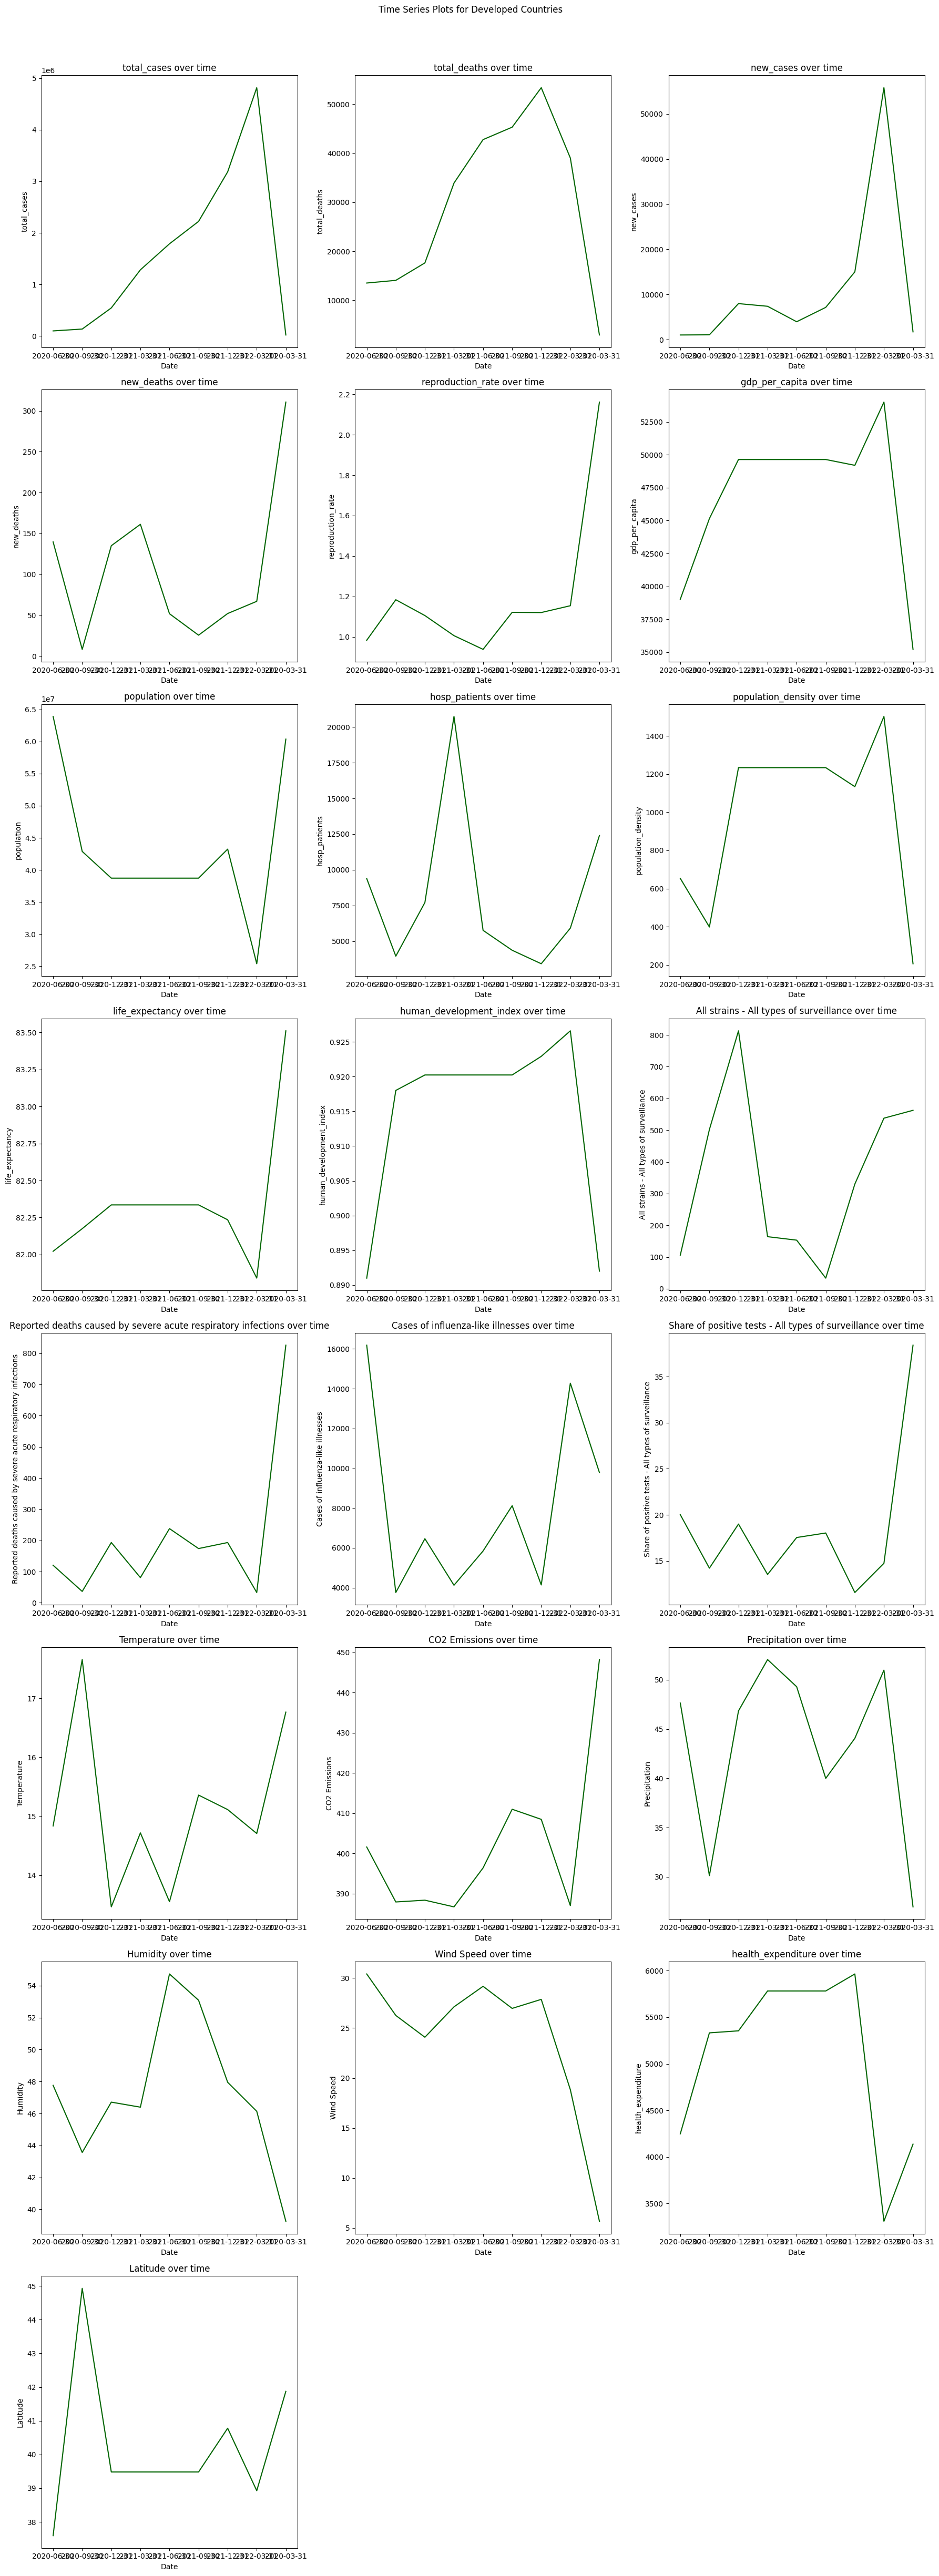

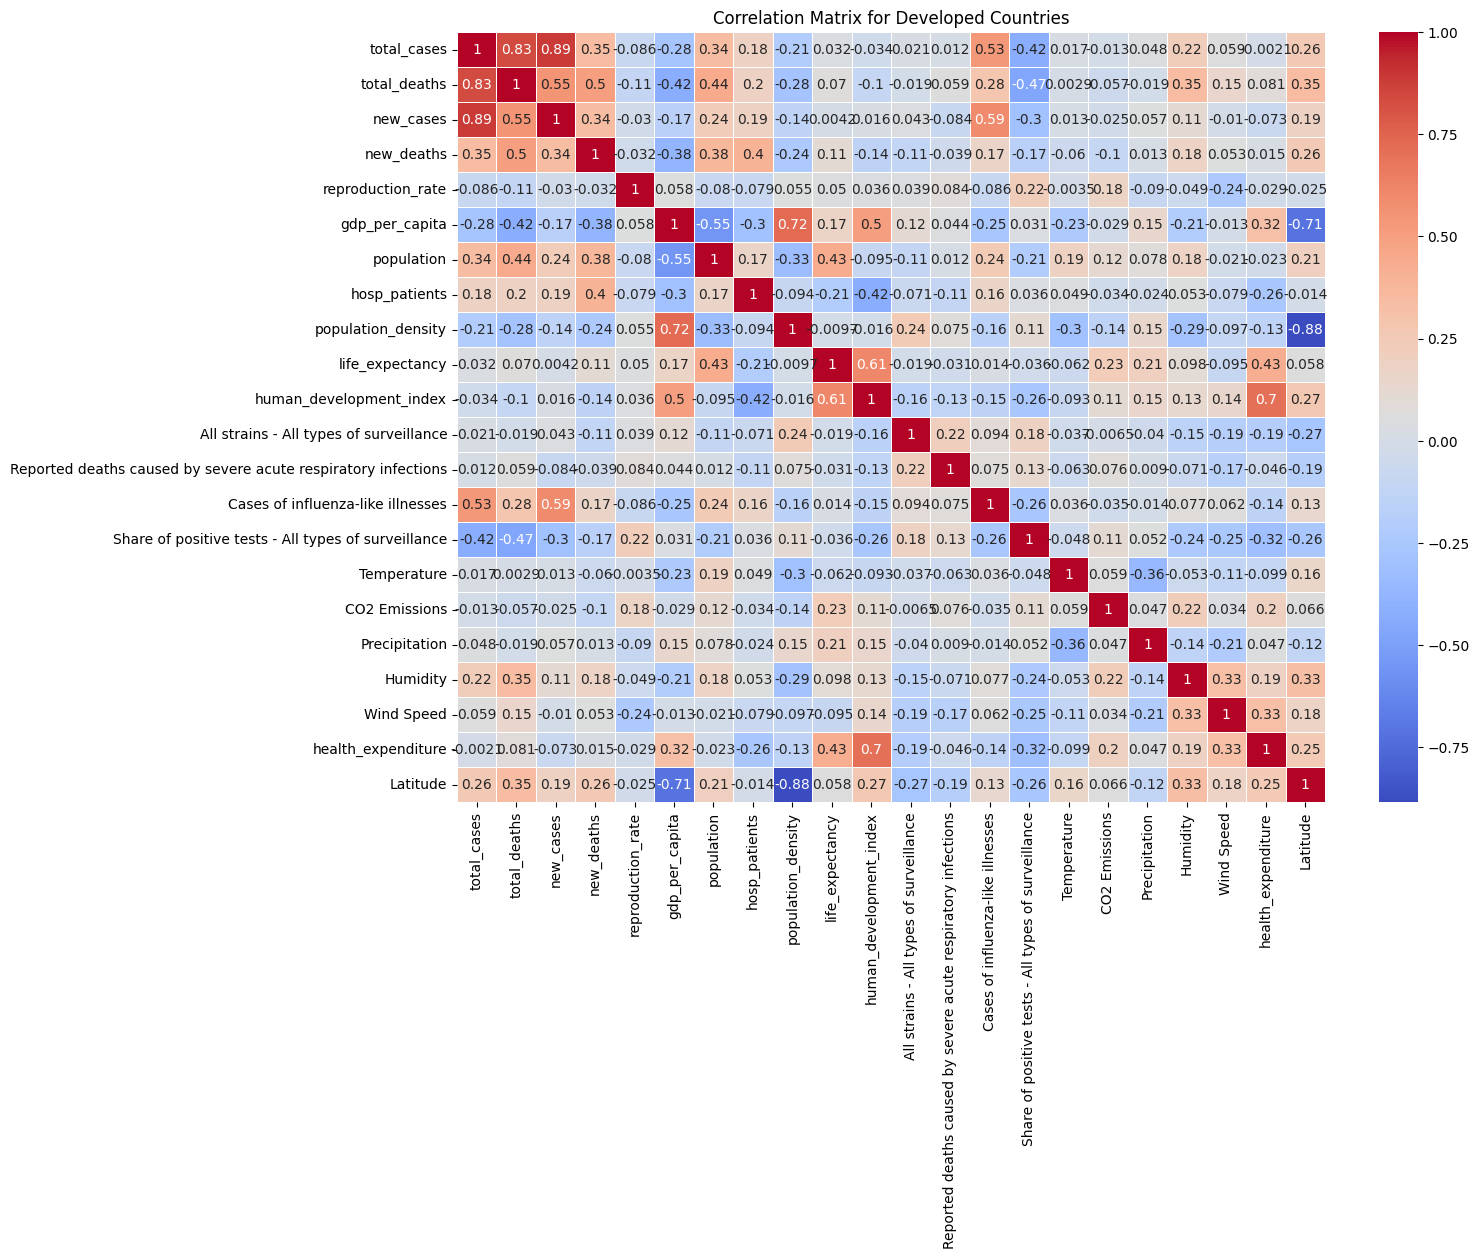


--- EDA for Developing Countries ---
Dimensions of the dataset: (296, 24)

First few rows of the dataset:
      location        date   total_cases  total_deaths   new_cases  \
0  Afghanistan  2020-03-31     31.648649      2.333333    4.666667   
1  Afghanistan  2020-03-31     31.648649      2.333333    4.666667   
2  Afghanistan  2020-03-31     31.648649      2.333333    4.666667   
3  Afghanistan  2020-03-31     31.648649      2.333333    4.666667   
4  Afghanistan  2020-06-30  10984.142857    227.670330  343.725275   

   new_deaths  reproduction_rate  gdp_per_capita  population  hosp_patients  \
0    0.444444           1.513333        1803.987  39835428.0      12.939394   
1    0.444444           1.513333        1803.987  39835428.0      12.939394   
2    0.444444           1.513333        1803.987  39835428.0      12.939394   
3    0.444444           1.513333        1803.987  39835428.0      12.939394   
4    8.076923           1.312088        1803.987  39835428.0    1847.351648  

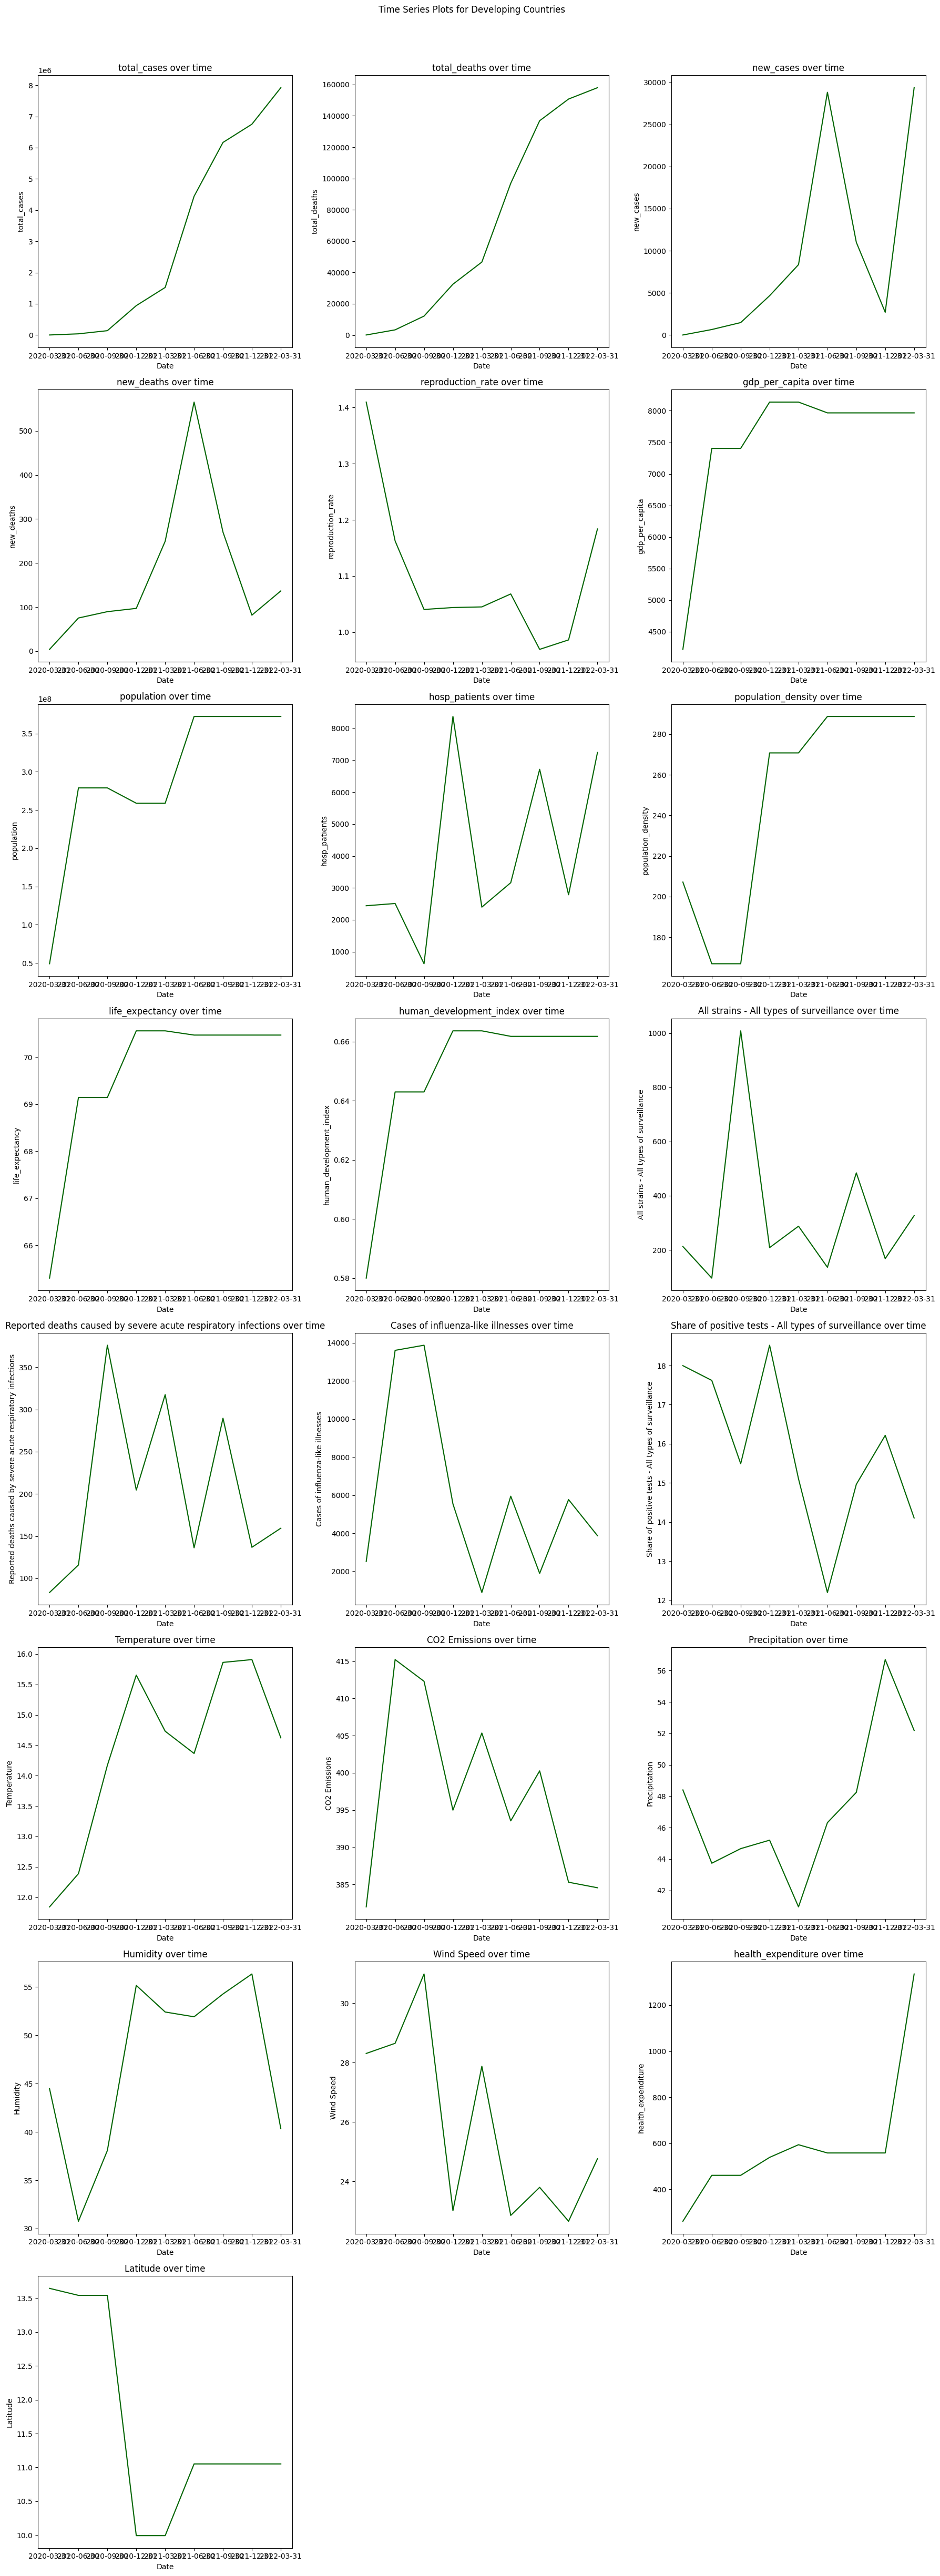

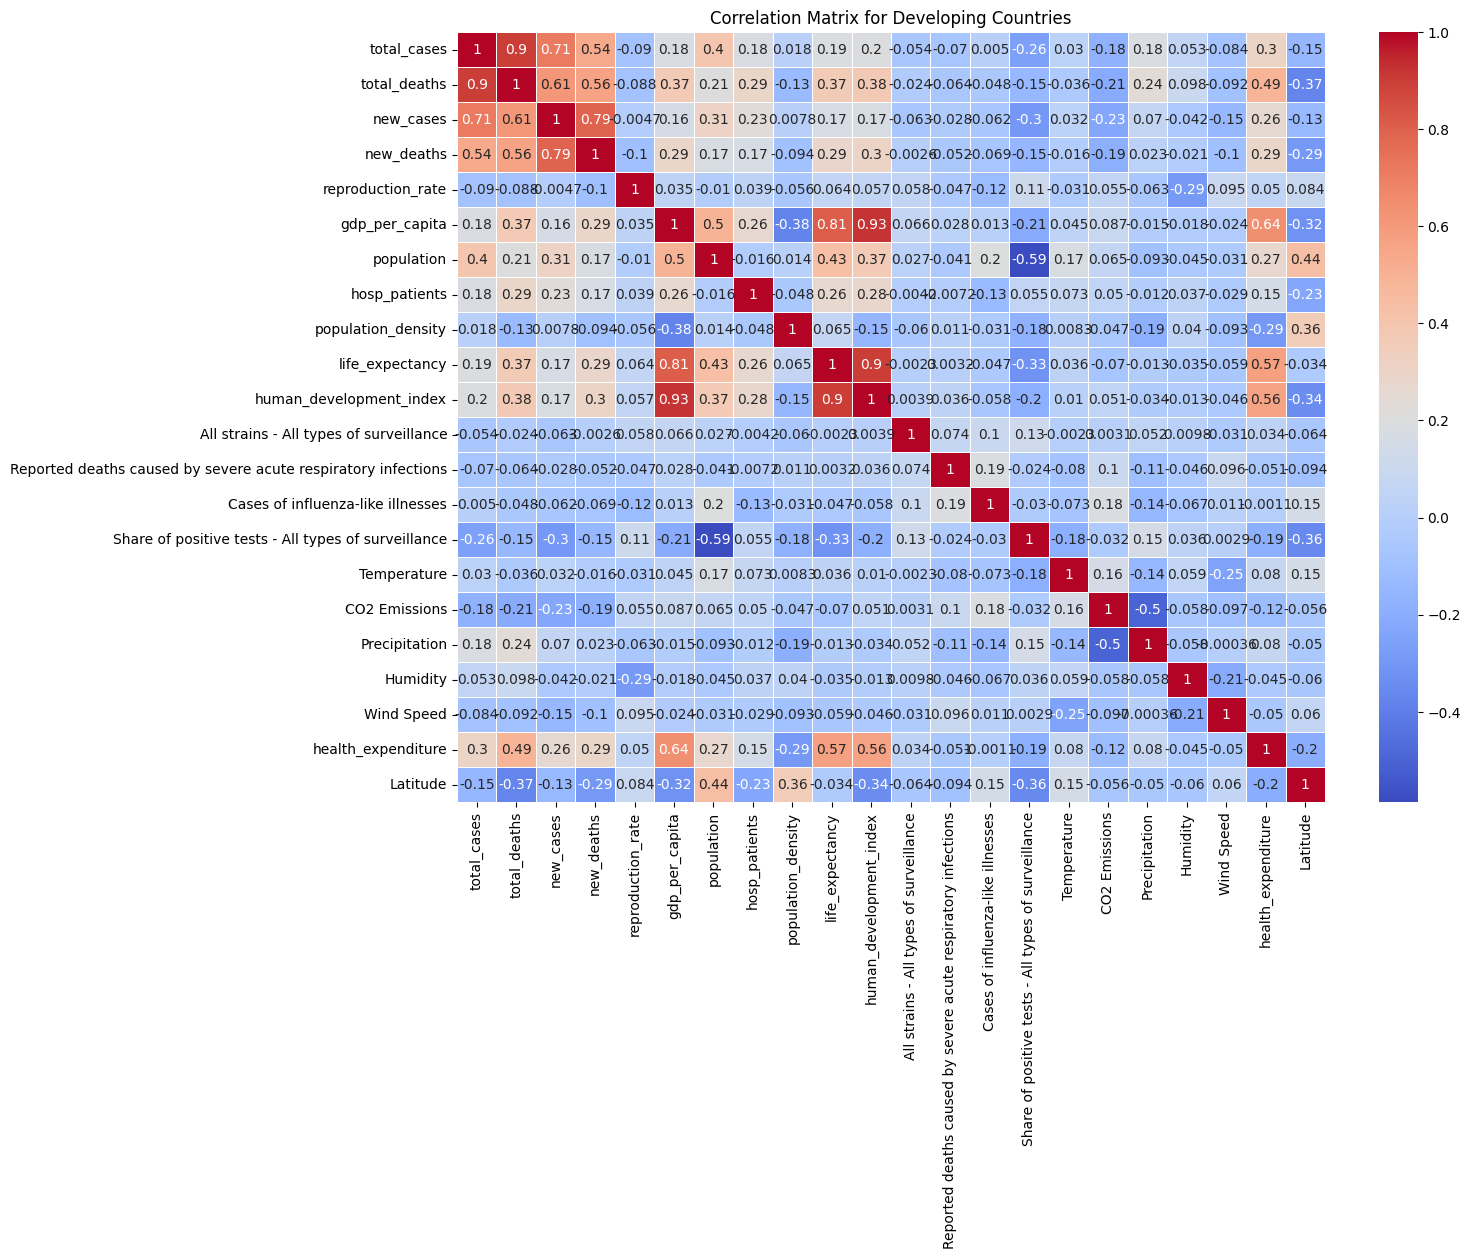


--- EDA for Underdeveloped Countries ---
Dimensions of the dataset: (304, 24)

First few rows of the dataset:
                     location        date  total_cases  total_deaths  \
884  Central African Republic  2020-03-31     2.411765     10.093750   
885  Central African Republic  2020-03-31     2.411765     10.093750   
886  Central African Republic  2020-03-31     2.411765     10.093750   
887  Central African Republic  2020-03-31     2.411765     10.093750   
888  Central African Republic  2020-06-30   907.120879     14.589744   

     new_cases  new_deaths  reproduction_rate  gdp_per_capita  population  \
884   0.176471    0.255556           0.573279          661.24   4919987.0   
885   0.176471    0.255556           0.573279          661.24   4919987.0   
886   0.176471    0.255556           0.573279          661.24   4919987.0   
887   0.176471    0.255556           0.573279          661.24   4919987.0   
888  41.120879    1.205128           1.045849          661.24   4919987

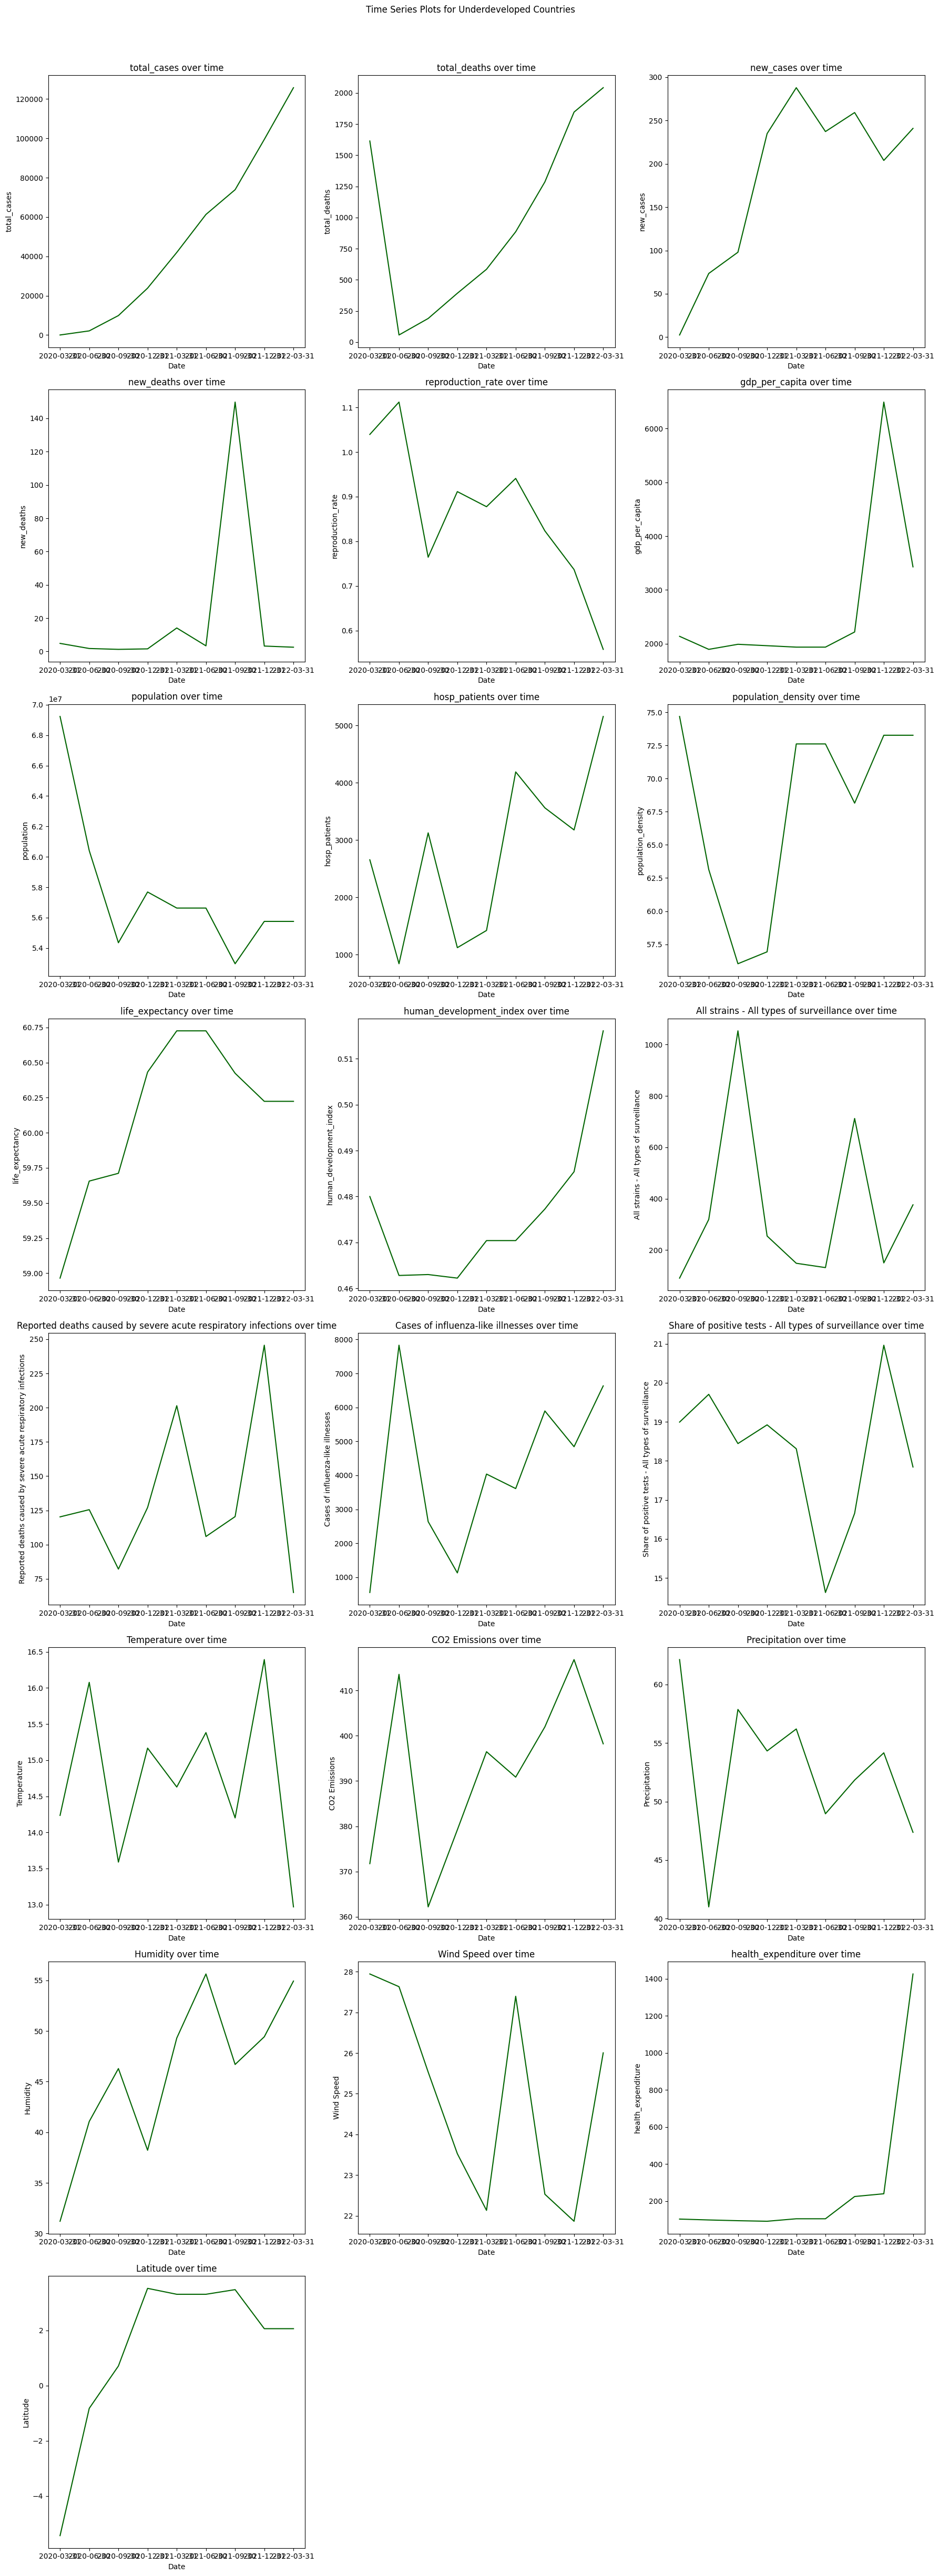

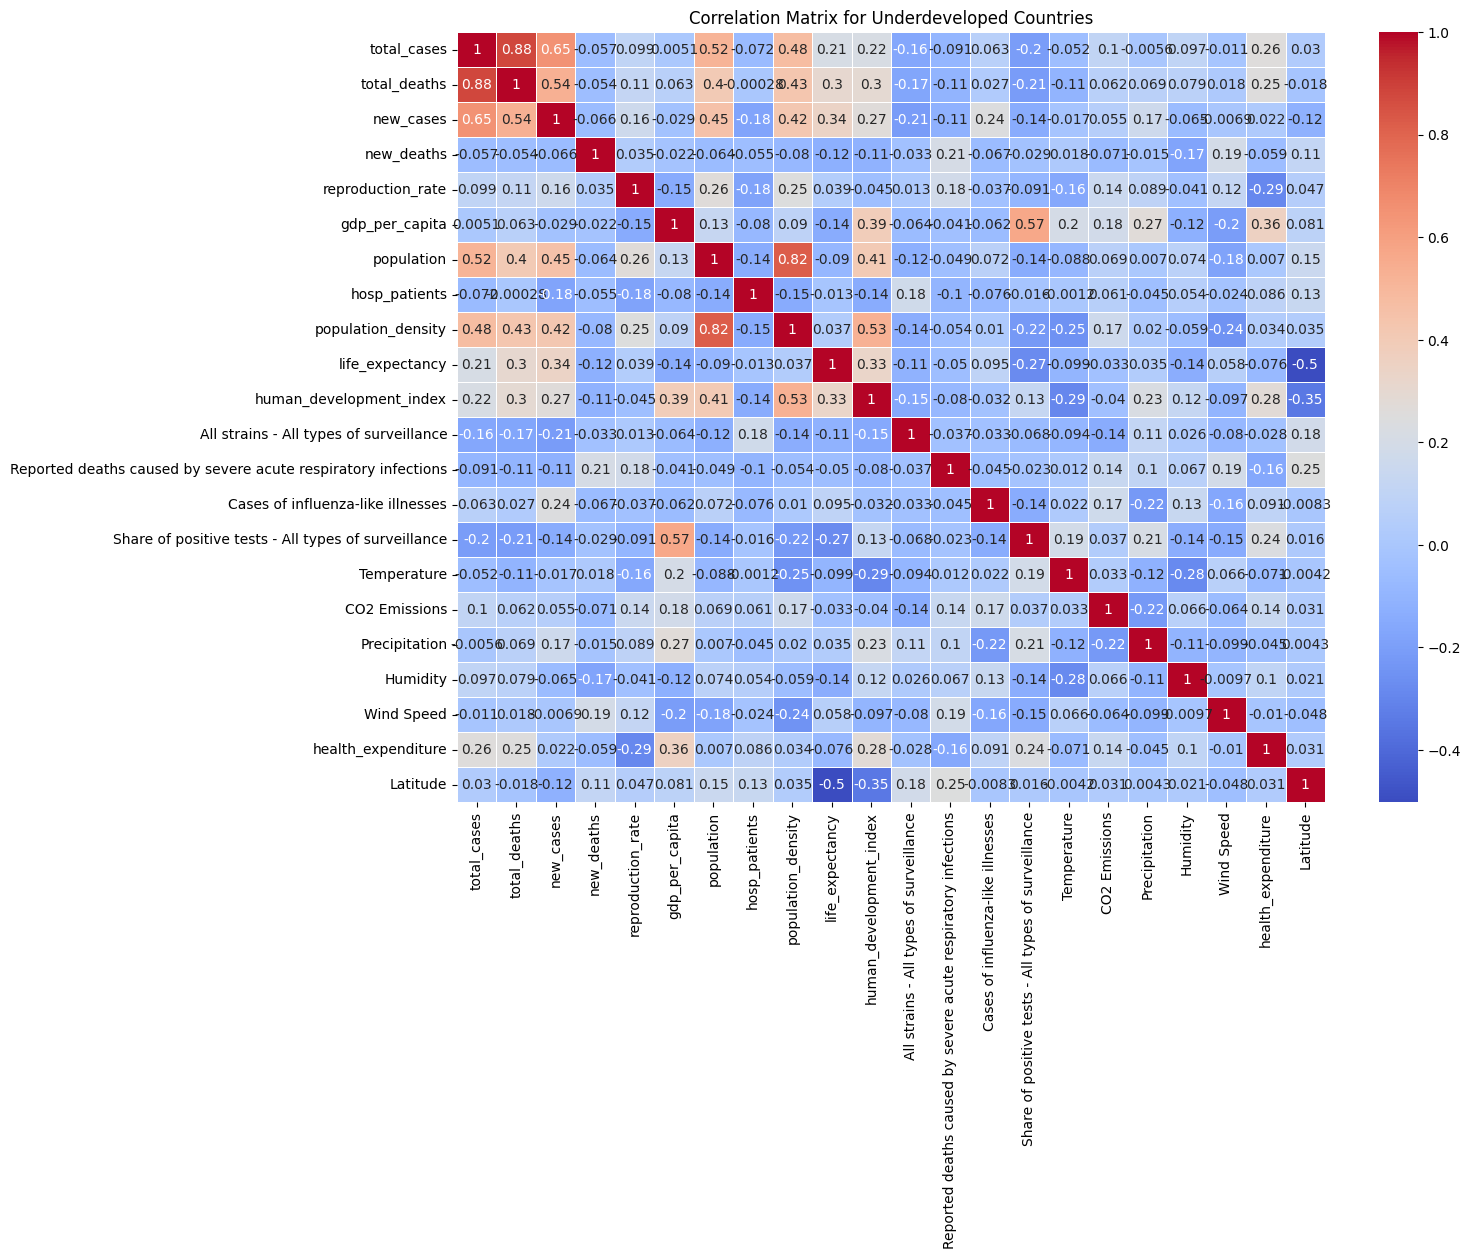


--- EDA for Island Countries ---
Dimensions of the dataset: (320, 24)

First few rows of the dataset:
      location        date  total_cases   total_deaths  new_cases  new_deaths  \
1176  Dominica  2020-03-31     7.900000  220484.956044   1.200000    0.428571   
1177  Dominica  2020-03-31     7.900000  220484.956044   1.200000    0.428571   
1178  Dominica  2020-03-31     7.900000  220484.956044   1.200000    0.428571   
1179  Dominica  2020-03-31     7.900000  220484.956044   1.200000    0.428571   
1180  Dominica  2020-06-30    16.417582  105840.043478   0.065934    4.888889   

      reproduction_rate  gdp_per_capita  population  hosp_patients  ...  \
1176           1.032609        9673.367     72172.0      55.393939  ...   
1177           1.032609        9673.367     72172.0      55.393939  ...   
1178           1.032609        9673.367     72172.0      55.393939  ...   
1179           1.032609        9673.367     72172.0      55.393939  ...   
1180           1.072088        9673

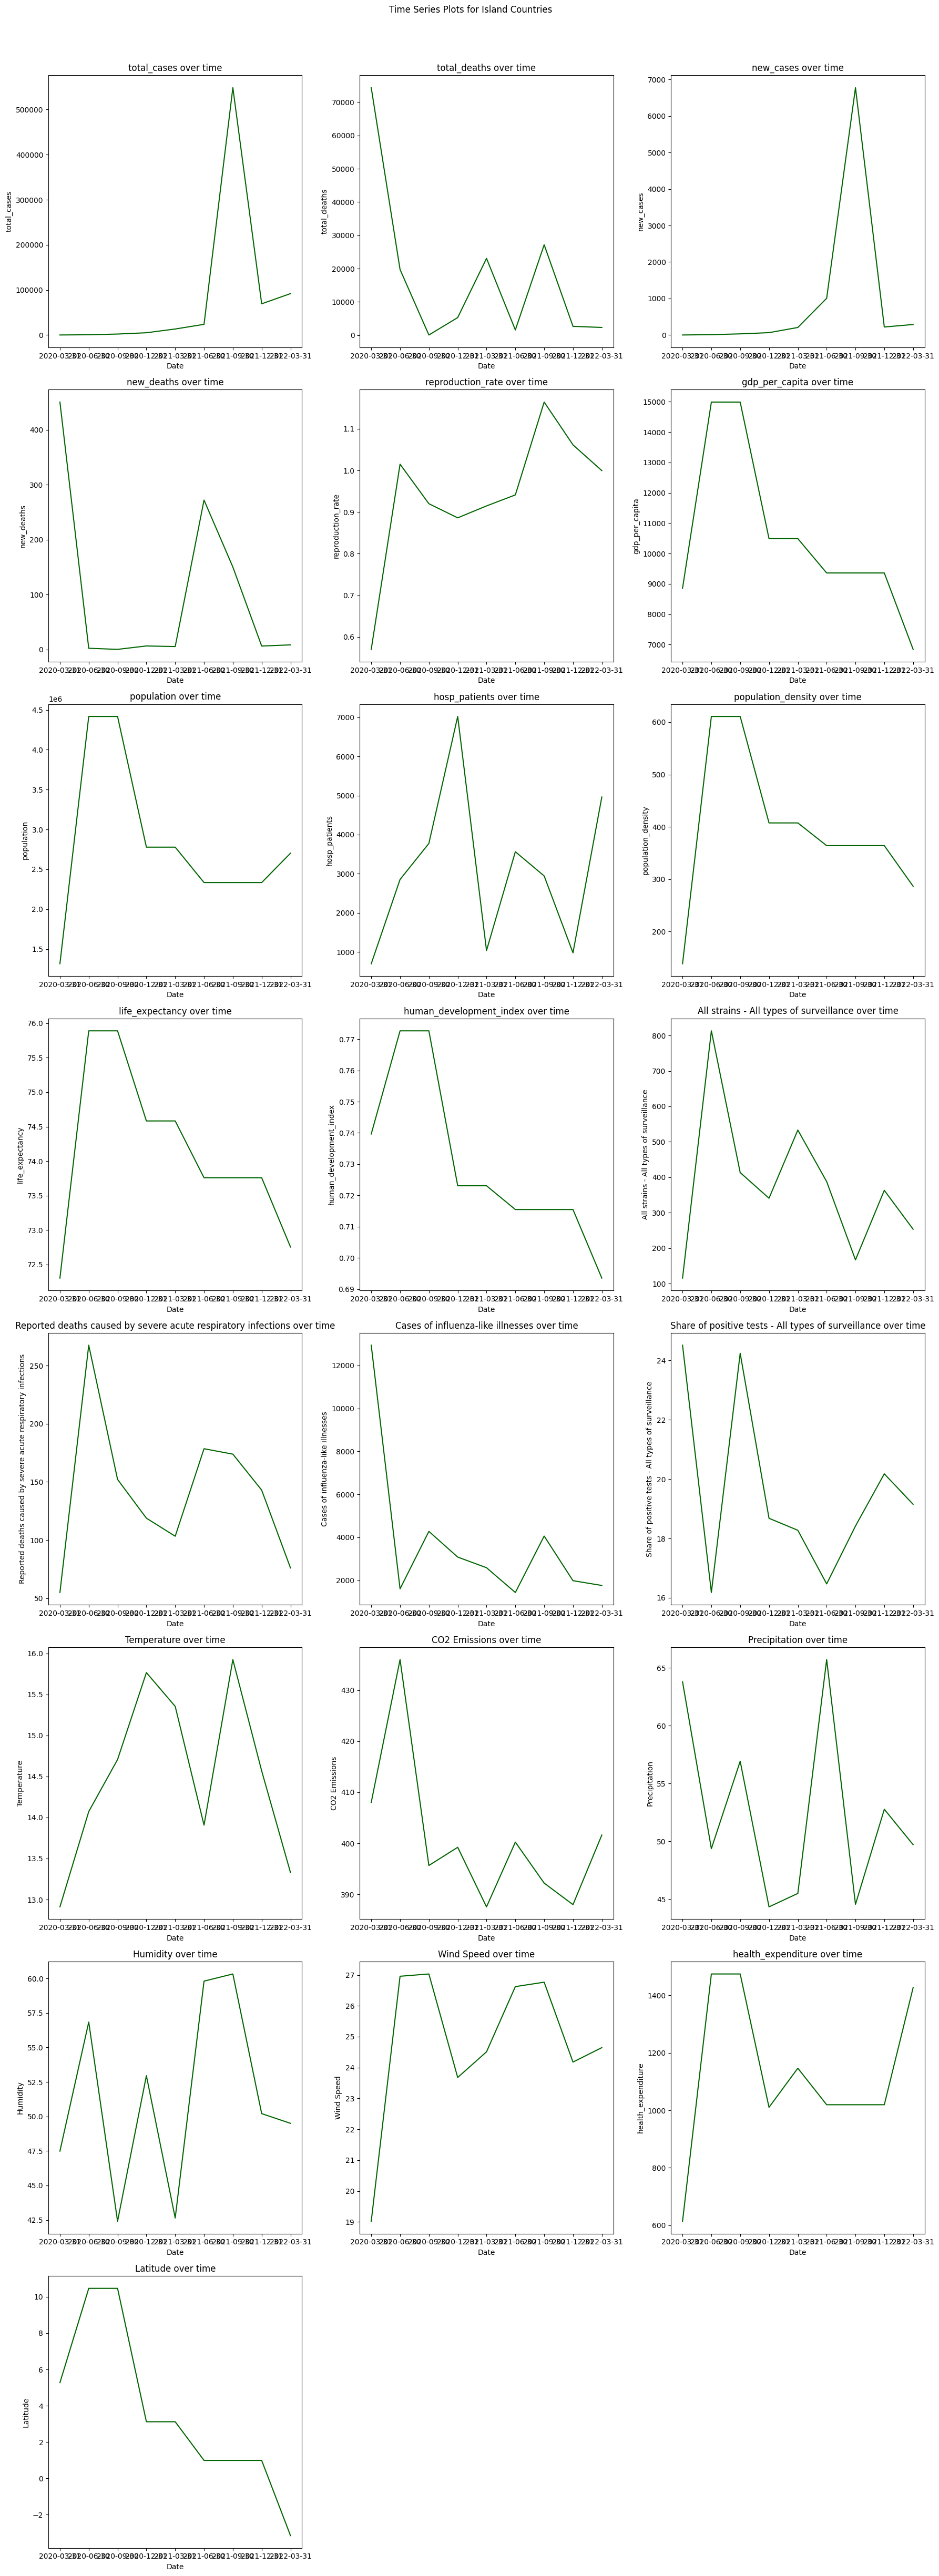

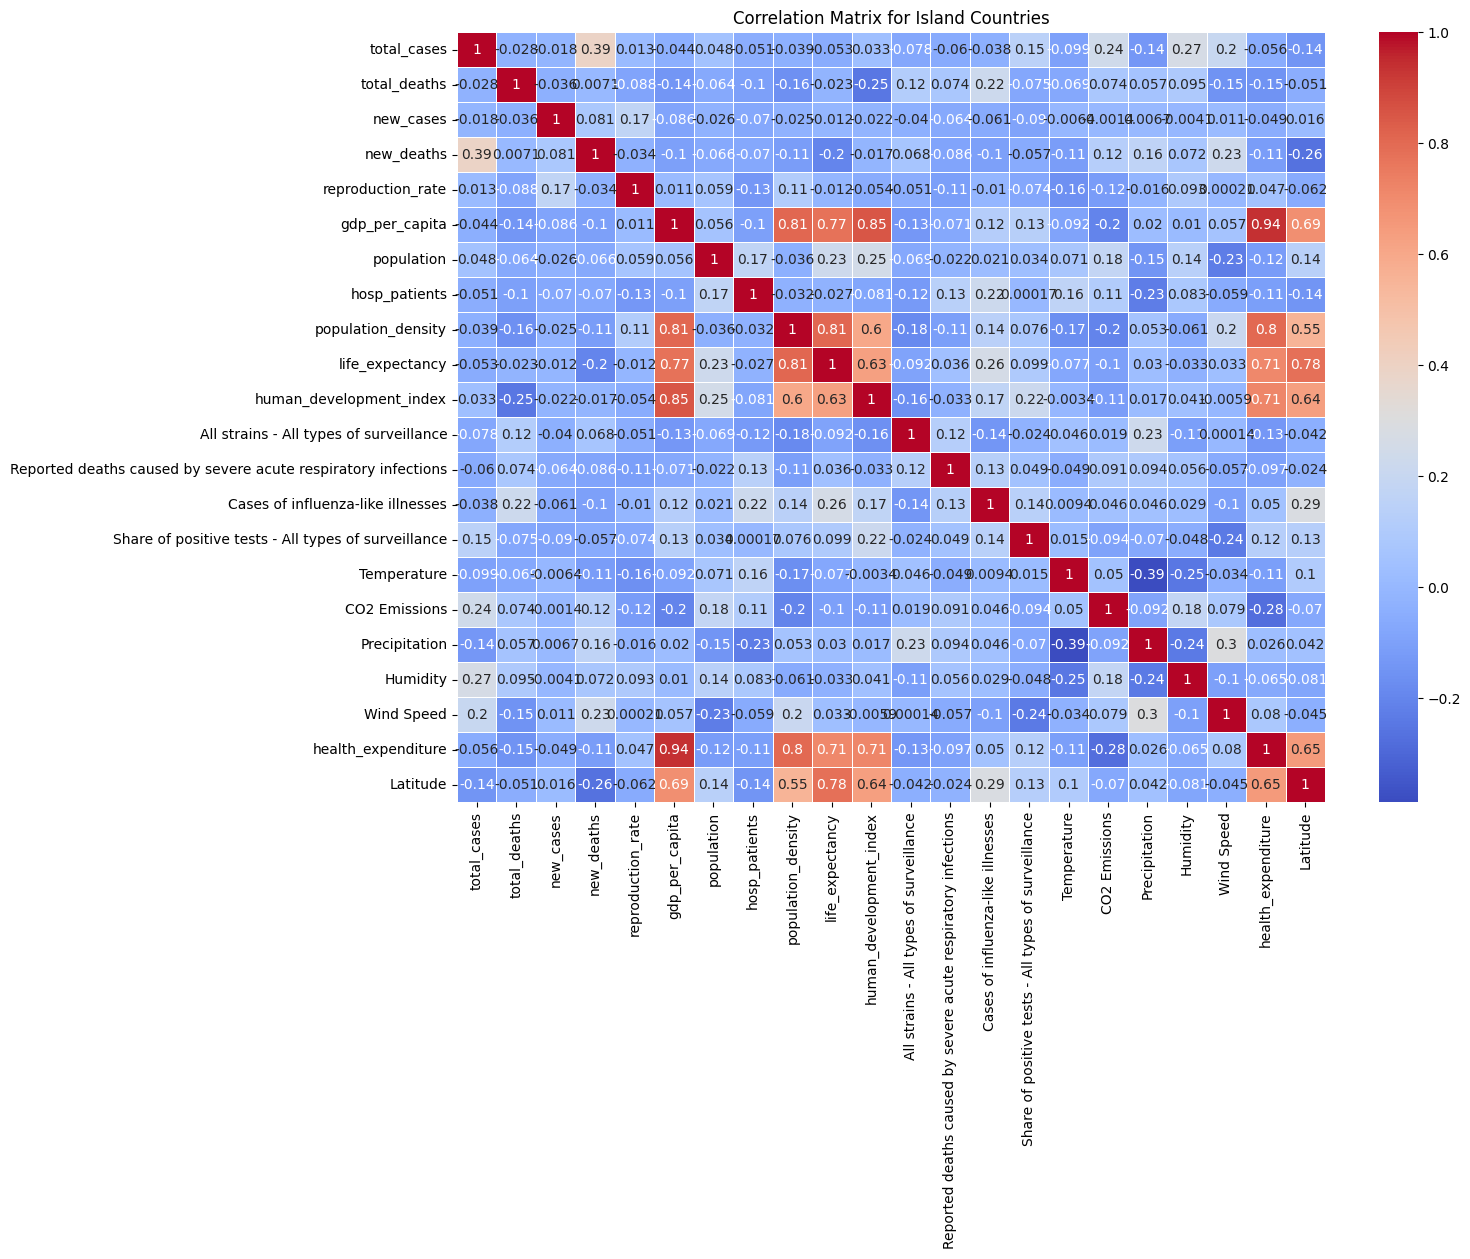

In [76]:
#EDA

# Define country lists for each category
developed_nations = ['Bahrain', 'Finland','France', 'Germany','Japan', 'Ireland', 'Italy', 'Netherlands','Singapore','Switzerland', 'United Kingdom', 'United States']
developing_nations = ['China','India','Peru','Philippines','Brazil','Bangladesh','Angola','Haiti','Indonesia','Afghanistan',]
underdeveloped_nations = ['Nigeria', 'Chad', 'Ethiopia', 'Mali', 'Madagascar','Niger','Mozambique','kenya', 'Tanzania','Somalia','Uganda','Central African Republic']
island_nations = ['Marshall Islands', 'St. Vincent and the Grenadines', 'Jamaica', 'Tonga', 'Kiribati', 'Dominica', 'Samoa', 'Fiji', 'Vanuatu', 'Solomon Islands', 'Maldives', 'Malta', 'Sri Lanka']

# Check for missing values and handle them
project_merged_data = project_merged_data.dropna(subset=['date', 'total_cases', 'total_deaths'])

# Define a function for EDA
def perform_eda(data, category_name):
    print(f"\n--- EDA for {category_name} Countries ---")

    if data.empty:
        print(f"No data available for {category_name} countries.")
        return

    # Check the dimensions of the dataset
    print("Dimensions of the dataset:", data.shape)

    # Display the first few rows
    print("\nFirst few rows of the dataset:")
    print(data.head())

    # Check for missing values
    print("\nMissing values in each column:")
    print(data.isnull().sum())

    # Summary statistics
    print("\nSummary statistics for numerical variables:")
    print(data.describe())

# Univariate Analysis with line plots
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    num_plots = len(numeric_columns)
    num_cols = 3
    num_rows = (num_plots // num_cols) + (num_plots % num_cols > 0)

    plt.figure(figsize=(18, num_rows * 6))
    for i, column in enumerate(numeric_columns):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.lineplot(x=data['date'], y=data[column], errorbar=None, color='darkgreen')
        plt.title(f'{column} over time')
        plt.xlabel('Date')
        plt.ylabel(column)

    plt.tight_layout()
    plt.suptitle(f'Time Series Plots for {category_name} Countries', y=1.02)
    plt.show()



    # Correlation matrix
    numeric_data = data.select_dtypes(include=[np.number])
    if not numeric_data.empty:
        plt.figure(figsize=(14, 10))
        correlation_matrix = numeric_data.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title(f'Correlation Matrix for {category_name} Countries')
        plt.show()
    else:
        print("No numeric data available for correlation matrix.")


# Filter data for each category
developed_countries_data = project_merged_data[project_merged_data['location'].isin(developed_nations)]
developing_countries_data = project_merged_data[project_merged_data['location'].isin(developing_nations)]
underdeveloped_countries_data = project_merged_data[project_merged_data['location'].isin(underdeveloped_nations)]
island_countries_data = project_merged_data[project_merged_data['location'].isin(island_nations)]

# Perform EDA for each category
perform_eda(developed_countries_data, "Developed")
perform_eda(developing_countries_data, "Developing")
perform_eda(underdeveloped_countries_data, "Underdeveloped")
perform_eda(island_countries_data, "Island")

In [20]:
# Check for missing values
missing_values = project_merged_data.isnull().sum()
print(missing_values[missing_values > 0])


Latitude    228
dtype: int64


In [80]:
#MODEL

# Define country lists for each category
developed_nations = ['Bahrain', 'Finland','France', 'Germany','Japan', 'Ireland', 'Italy', 'Netherlands','Singapore','Switzerland', 'United Kingdom', 'United States']
developing_nations = ['China','India','Peru','Philippines','Brazil','Bangladesh','Angola','Haiti','Indonesia','Afghanistan',]
underdeveloped_nations = ['Nigeria', 'Chad', 'Ethiopia', 'Mali', 'Madagascar','Niger','Mozambique','kenya', 'Tanzania','Somalia','Uganda','Central African Republic']
island_nations = ['Marshall Islands', 'St. Vincent and the Grenadines', 'Jamaica', 'Tonga', 'Kiribati', 'Dominica', 'Samoa', 'Fiji', 'Vanuatu', 'Solomon Islands', 'Maldives', 'Malta', 'Sri Lanka']

# Filter data for each category
developed_countries_data = project_merged_data[project_merged_data['location'].isin(developed_nations)]
developing_countries_data = project_merged_data[project_merged_data['location'].isin(developing_nations)]
underdeveloped_countries_data = project_merged_data[project_merged_data['location'].isin(underdeveloped_nations)]
island_countries_data = project_merged_data[project_merged_data['location'].isin(island_nations)]

# Drop the 'Country' column as it is not needed for modeling
developed_countries_data = developed_countries_data.drop(columns=['location'])
developing_countries_data = developing_countries_data.drop(columns=['location'])
underdeveloped_countries_data = underdeveloped_countries_data.drop(columns=['location'])
island_countries_data = island_countries_data.drop(columns=['location'])


In [81]:
def preprocess_data(data):
    # One-hot encode categorical variables if any
    data = pd.get_dummies(data, drop_first=True)
    return data

# Apply preprocessing
developed_data = preprocess_data(developed_countries_data)
developing_data = preprocess_data(developing_countries_data)
underdeveloped_data = preprocess_data(underdeveloped_countries_data)
island_data = preprocess_data(island_countries_data)


In [84]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model_name} - RMSE: {rmse}")

def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(title)
    plt.show()


Developed - XGBoost - RMSE: 0.4807827863071294


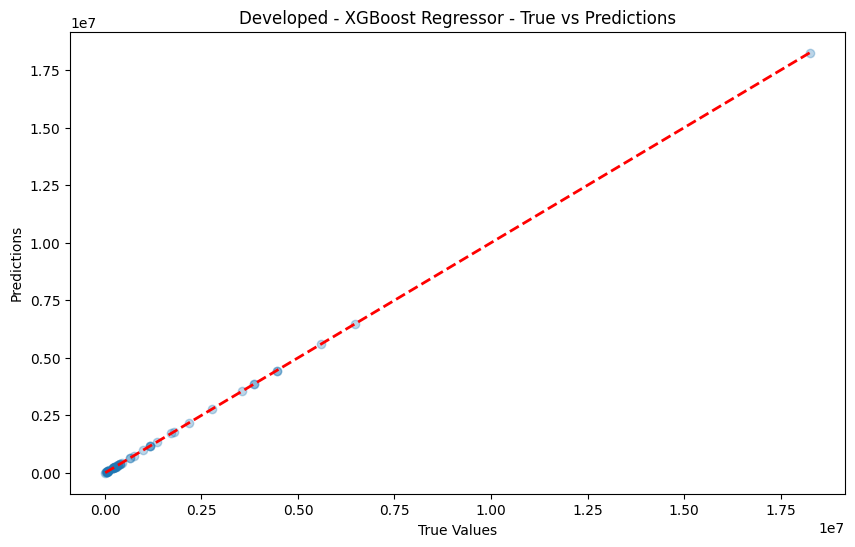

Developing - XGBoost - RMSE: 1.610647876802354


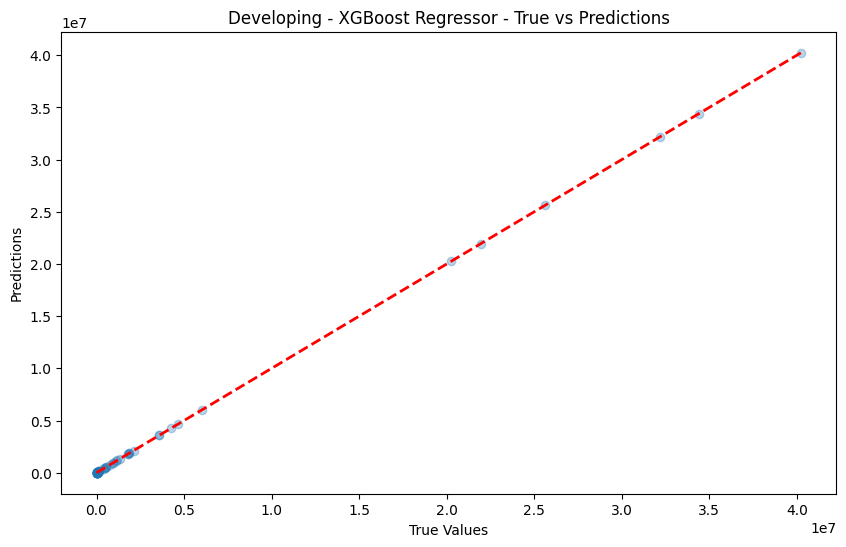

Underdeveloped - XGBoost - RMSE: 0.044112837646684284


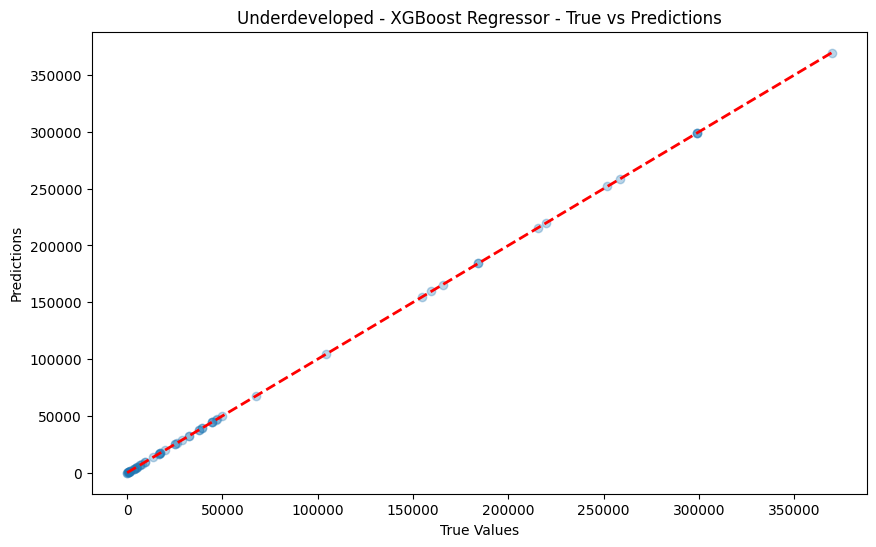

Island - XGBoost - RMSE: 0.20024253287414107


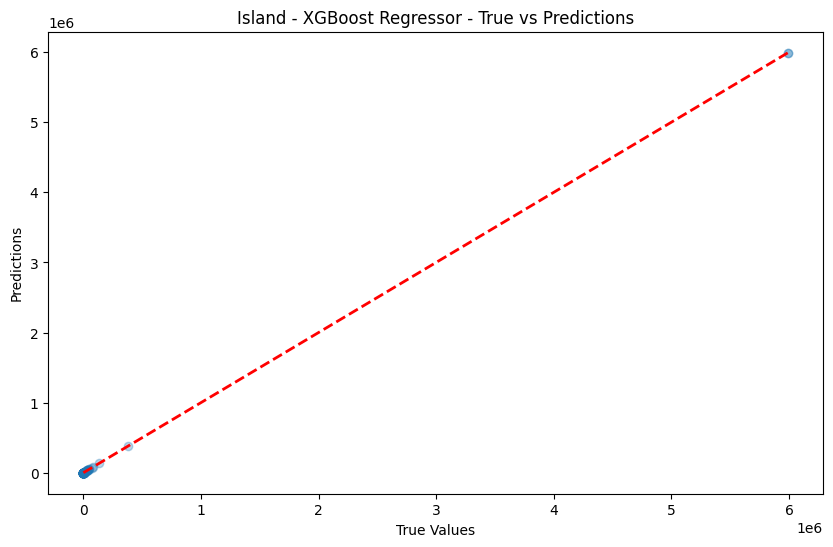

In [83]:
from xgboost import XGBRegressor

def train_evaluate_xgboost(data, category_name):
    # Split the data
    X = data.drop('total_cases', axis=1)
    y = data['total_cases']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate XGBoost
    xgb_model = XGBRegressor(random_state=42)
    xgb_model.fit(X_train_scaled, y_train)
    xgb_pred_test = xgb_model.predict(X_test_scaled)

    evaluate_model(f"{category_name} - XGBoost", y_test, xgb_pred_test)
    plot_results(y_test, xgb_pred_test, f'{category_name} - XGBoost Regressor - True vs Predictions')

# Apply the XGBoost function to each category
train_evaluate_xgboost(developed_data, "Developed")
train_evaluate_xgboost(developing_data, "Developing")
train_evaluate_xgboost(underdeveloped_data, "Underdeveloped")
train_evaluate_xgboost(island_data, "Island")


Developed - Bagging - RMSE: 99222.10016960962


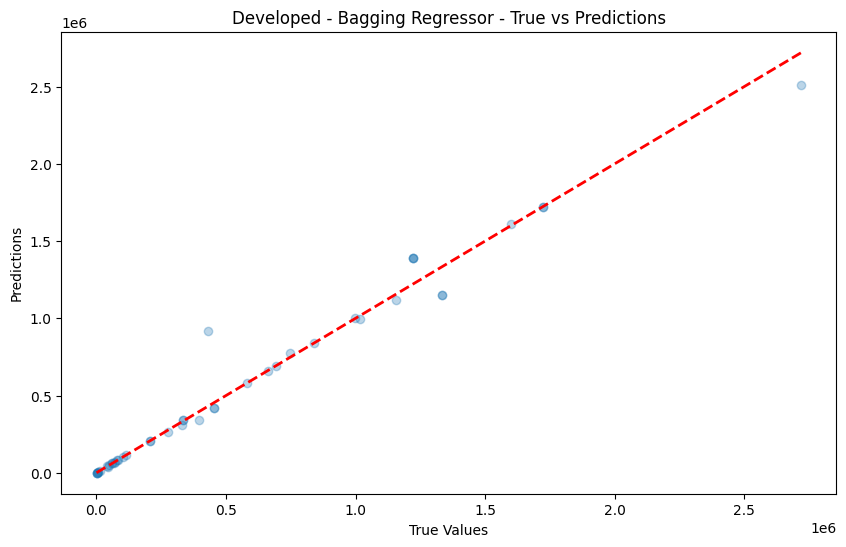

Developing - Bagging - RMSE: 269334.7001225195


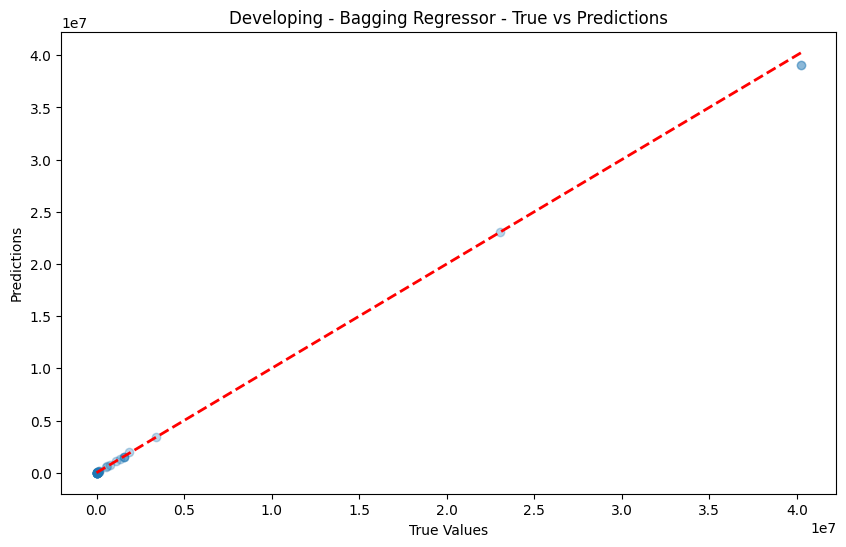

Underdeveloped - Bagging - RMSE: 1042.6742253460977


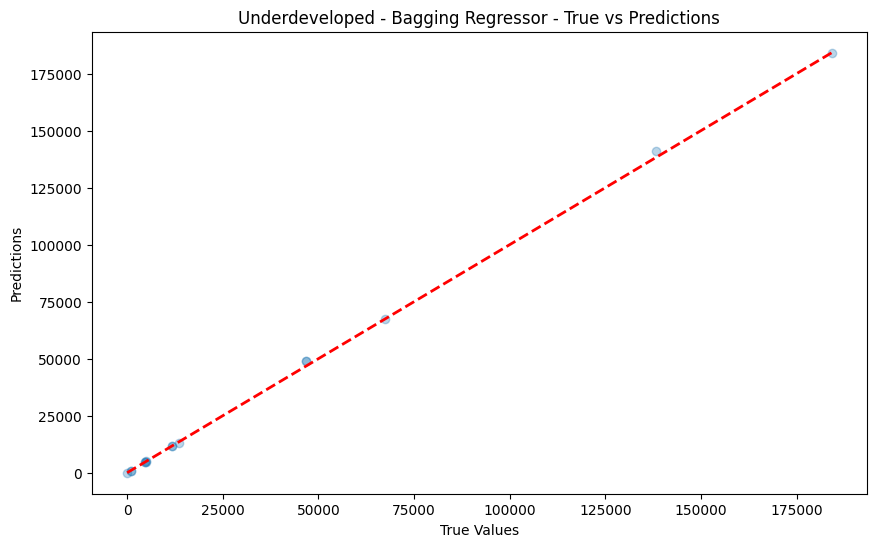

Island - Bagging - RMSE: 129942.87993141776


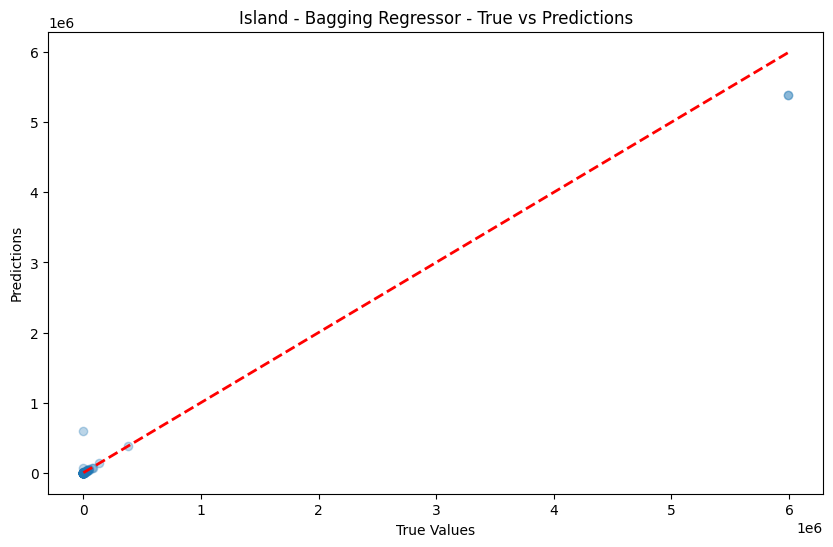

In [46]:
from sklearn.ensemble import BaggingRegressor

def train_evaluate_bagging(data, category_name):
    # Split the data
    X = data.drop('total_cases', axis=1)
    y = data['total_cases']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate Bagging Regressor
    bagging_model = BaggingRegressor(random_state=42)
    bagging_model.fit(X_train_scaled, y_train)
    bagging_pred_test = bagging_model.predict(X_test_scaled)

    evaluate_model(f"{category_name} - Bagging", y_test, bagging_pred_test)
    plot_results(y_test, bagging_pred_test, f'{category_name} - Bagging Regressor - True vs Predictions')

# Apply the Bagging function to each category
train_evaluate_bagging(developed_data, "Developed")
train_evaluate_bagging(developing_data, "Developing")
train_evaluate_bagging(underdeveloped_data, "Underdeveloped")
train_evaluate_bagging(island_data, "Island")


Developed - Voting - RMSE: 49611.06081065601


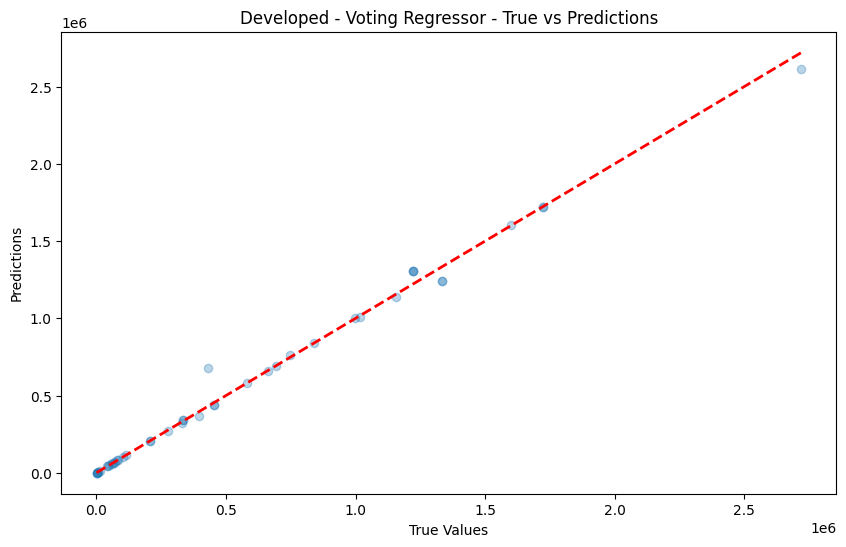

Developing - Voting - RMSE: 134668.4684607763


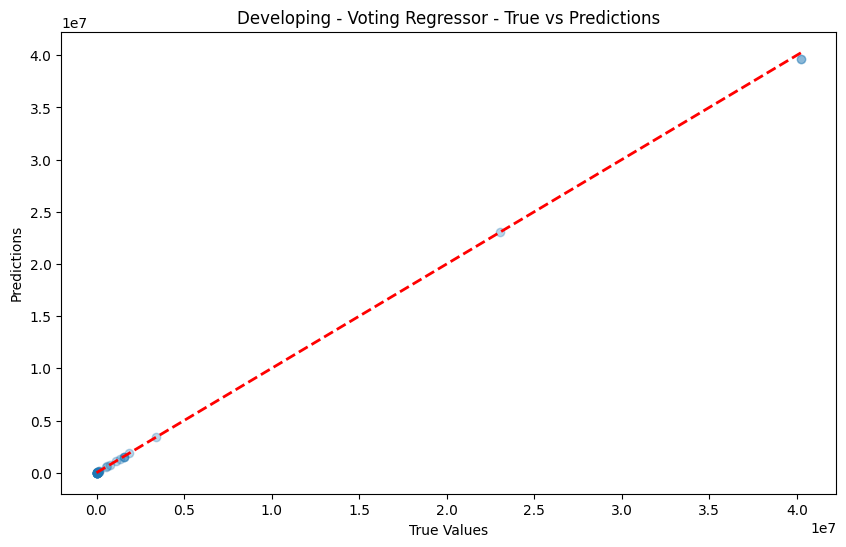

Underdeveloped - Voting - RMSE: 521.336329709109


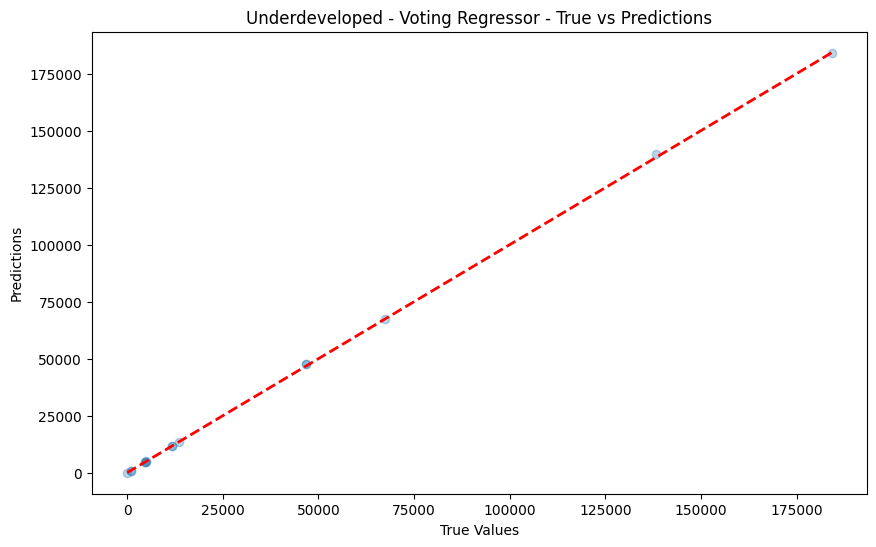

Island - Voting - RMSE: 64971.521262088434


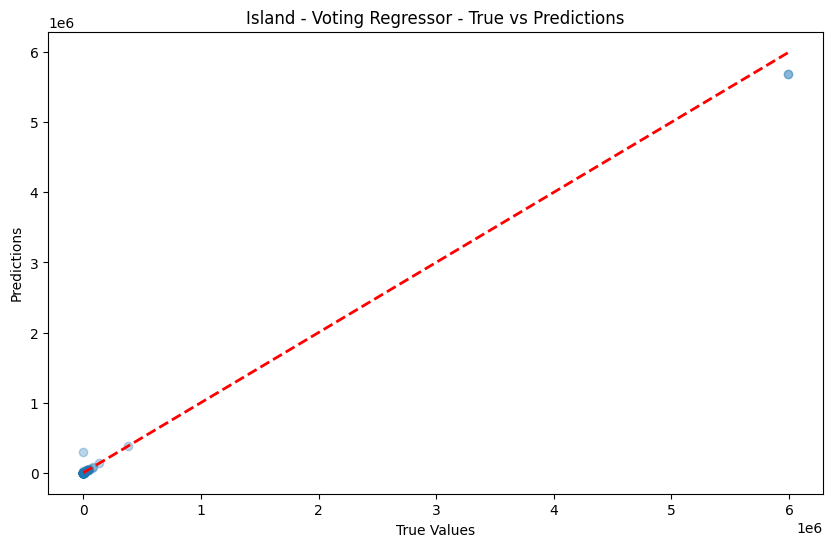

In [47]:
from sklearn.ensemble import VotingRegressor

def train_evaluate_voting(data, category_name):
    # Split the data
    X = data.drop('total_cases', axis=1)
    y = data['total_cases']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the individual models
    xgb_model = XGBRegressor(random_state=42)
    bagging_model = BaggingRegressor(random_state=42)

    # Train and evaluate Voting Regressor
    voting_model = VotingRegressor(estimators=[
        ('xgb', xgb_model),
        ('bagging', bagging_model)
    ])
    voting_model.fit(X_train_scaled, y_train)
    voting_pred_test = voting_model.predict(X_test_scaled)

    evaluate_model(f"{category_name} - Voting", y_test, voting_pred_test)
    plot_results(y_test, voting_pred_test, f'{category_name} - Voting Regressor - True vs Predictions')

# Apply the Voting function to each category
train_evaluate_voting(developed_data, "Developed")
train_evaluate_voting(developing_data, "Developing")
train_evaluate_voting(underdeveloped_data, "Underdeveloped")
train_evaluate_voting(island_data, "Island")


In [96]:
# Define the target variables
target_cases = 'total_cases'
target_deaths = 'total_deaths'

# Define the feature variables (independent variables)
features = [col for col in project_merged_data.columns if col not in [target_cases, target_deaths,'date', 'location']]



In [91]:
# Define country lists for each category
developed_nations = ['Bahrain', 'Finland','France', 'Germany','Japan', 'Ireland', 'Italy', 'Netherlands','Singapore','Switzerland', 'United Kingdom', 'United States']
developing_nations = ['China','India','Peru','Philippines','Brazil','Bangladesh','Angola','Haiti','Indonesia','Afghanistan',]
underdeveloped_nations = ['Nigeria', 'Chad', 'Ethiopia', 'Mali', 'Madagascar','Niger','Mozambique','kenya', 'Tanzania','Somalia','Uganda','Central African Republic']
island_nations = ['Marshall Islands', 'St. Vincent and the Grenadines', 'Jamaica', 'Tonga', 'Kiribati', 'Dominica', 'Samoa', 'Fiji', 'Vanuatu', 'Solomon Islands', 'Maldives', 'Malta', 'Sri Lanka']

# Filter data for each category
developed_countries_data = project_merged_data[project_merged_data['location'].isin(developed_nations)]
developing_countries_data = project_merged_data[project_merged_data['location'].isin(developing_nations)]
underdeveloped_countries_data = project_merged_data[project_merged_data['location'].isin(underdeveloped_nations)]
island_countries_data = project_merged_data[project_merged_data['location'].isin(island_nations)]


In [94]:
def preprocess_data(data):
    # One-hot encode categorical variables if any
    data = pd.get_dummies(data, drop_first=True)
    return data

# Apply preprocessing
developed_data = preprocess_data(developed_countries_data)
developing_data = preprocess_data(developing_countries_data)
underdeveloped_data = preprocess_data(underdeveloped_countries_data)
island_data = preprocess_data(island_countries_data)

Developed - XGBoost - total_cases - MSE: 0.1035332652863279, RMSE: 0.3217658547551743, MAE: 0.17517195961530282, R2: 0.9999999999999898


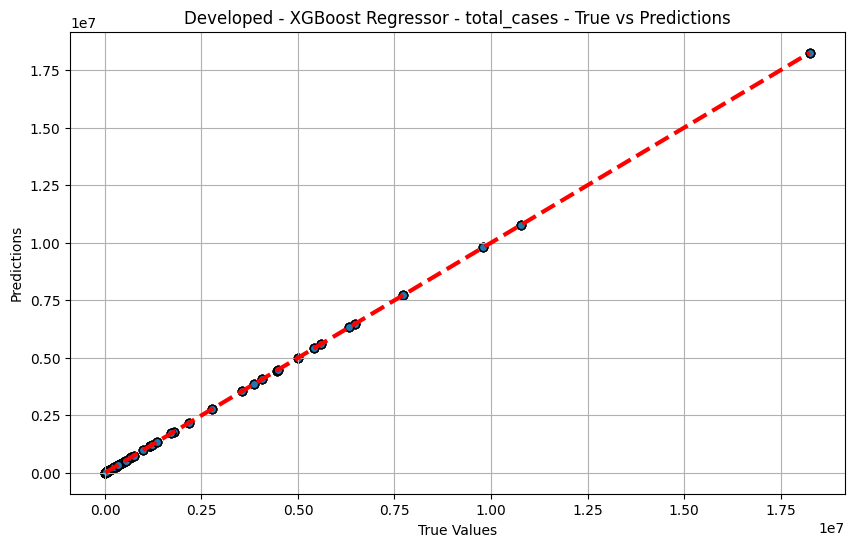

Developing - XGBoost - total_cases - MSE: 0.8120607066322054, RMSE: 0.9011441098027582, MAE: 0.32654851721302275, R2: 0.9999999999999889


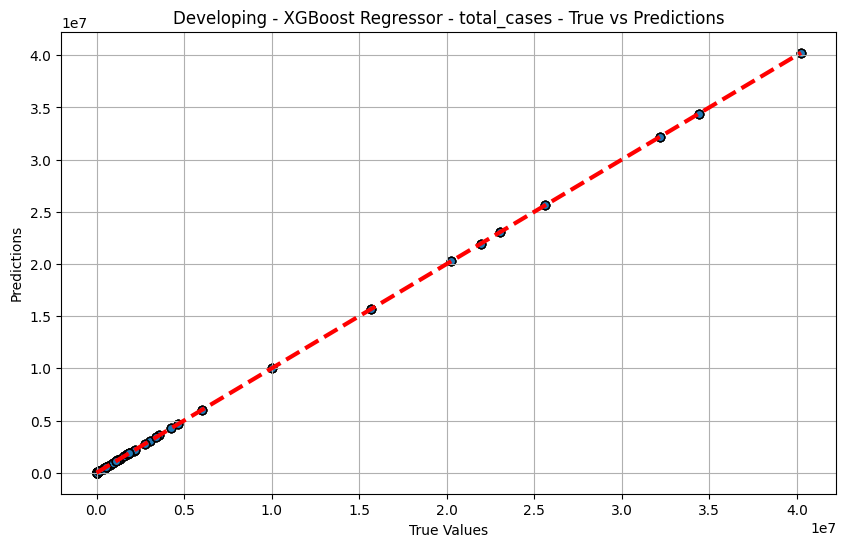

Underdeveloped - XGBoost - total_cases - MSE: 0.00016293815064052615, RMSE: 0.01276472289713044, MAE: 0.008454752383423251, R2: 0.9999999999999809


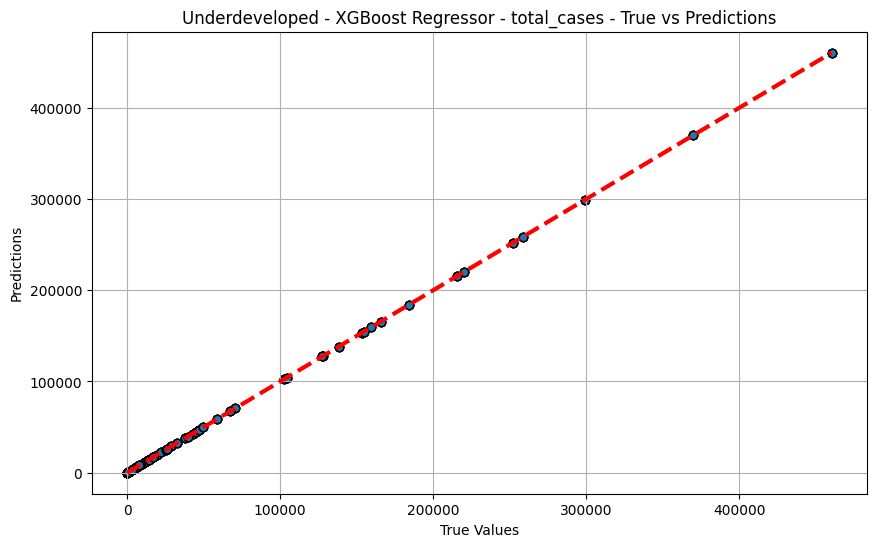

Island - XGBoost - total_cases - MSE: 0.005120333570906776, RMSE: 0.07155650613960114, MAE: 0.017070441563063008, R2: 0.9999999999999886


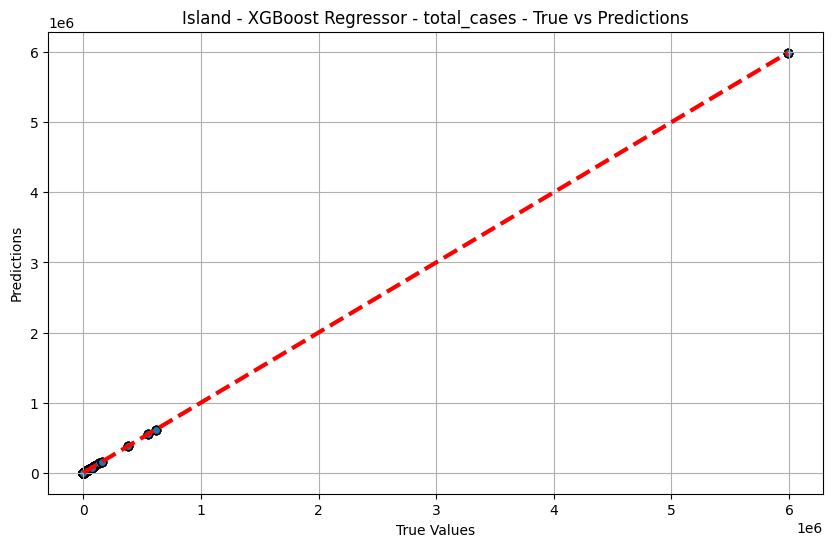

Developed - XGBoost - total_deaths - MSE: 2.0769498060786214e-05, RMSE: 0.00455735647725589, MAE: 0.0033149760880880653, R2: 0.9999999999999908


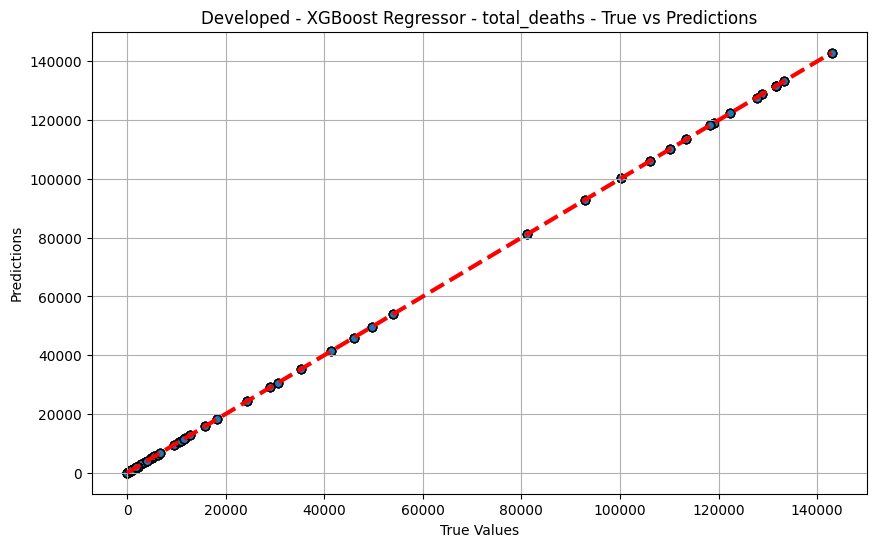

Developing - XGBoost - total_deaths - MSE: 0.00021586471694342904, RMSE: 0.014692335312789082, MAE: 0.008511390607534846, R2: 0.9999999999999912


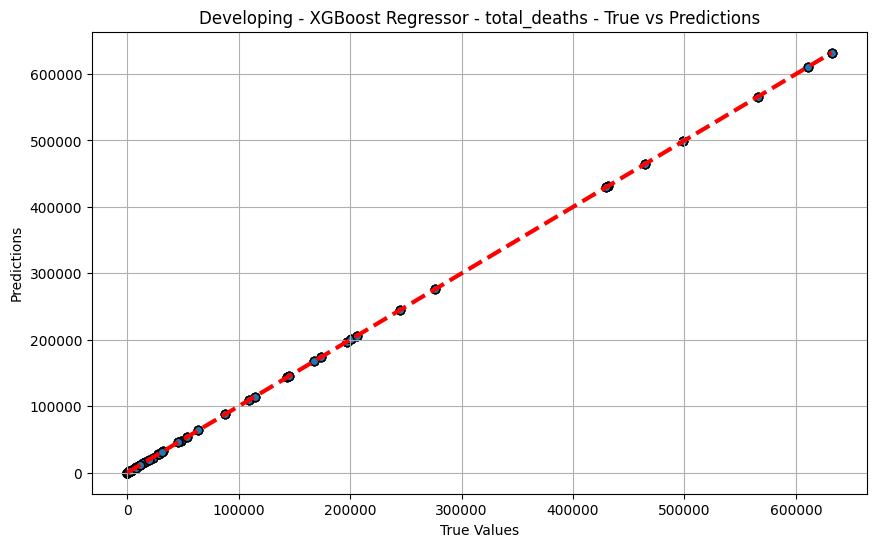

Underdeveloped - XGBoost - total_deaths - MSE: 8.879549799083423e-08, RMSE: 0.0002979857345425016, MAE: 0.00022897567139206444, R2: 0.999999999999961


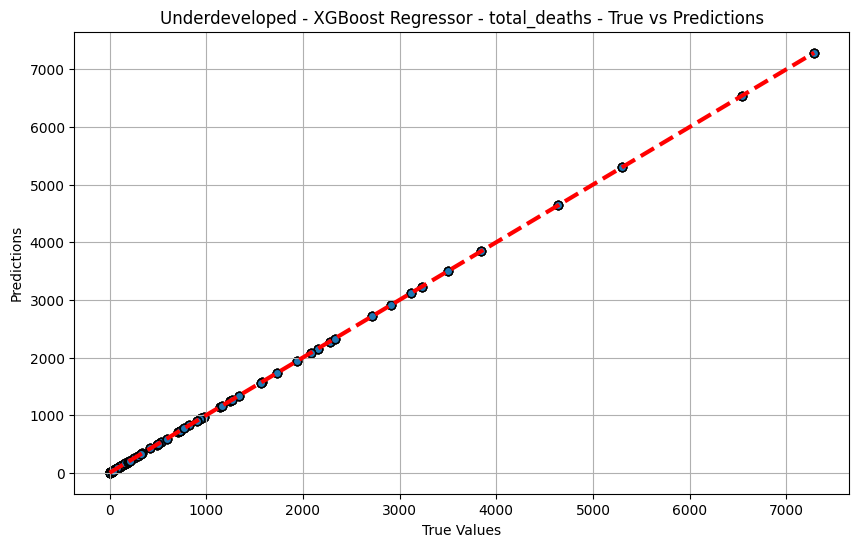

Island - XGBoost - total_deaths - MSE: 1.8076120247359675e-05, RMSE: 0.004251602080082246, MAE: 0.0022088349101162864, R2: 0.9999999999999922


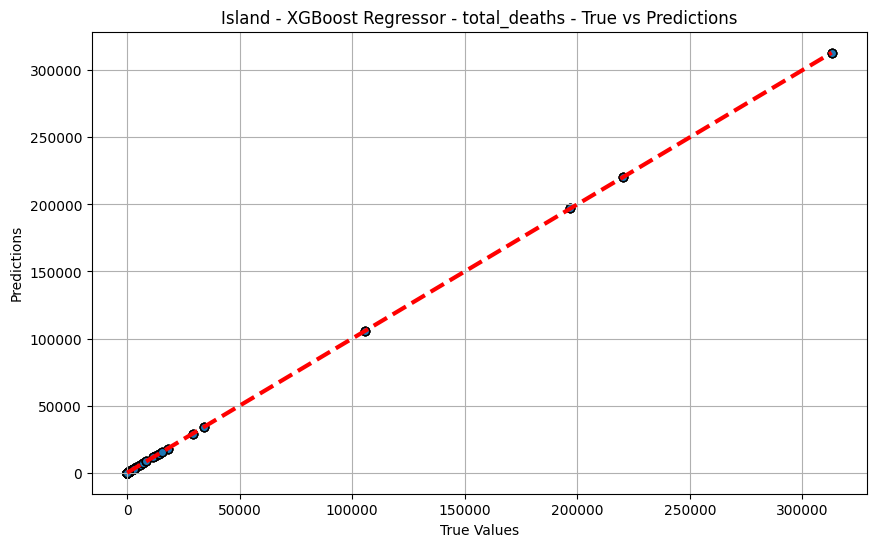

In [99]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Function to plot predictions
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, edgecolors=(0, 0, 0))
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=3)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Training and evaluation for XGBoost
def train_evaluate_xgboost(data, category, target):
    X = data[features]
    y = data[target]
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X, y)
    y_pred = model.predict(X)
    mse, rmse, mae, r2 = evaluate_model(y, y_pred)
    print(f'{category} - XGBoost - {target} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}')
    plot_predictions(y, y_pred, f"{category} - XGBoost Regressor - {target} - True vs Predictions")
    return model

# Apply the XGBoost model to each category for Total Cases
xgb_model_developed_cases = train_evaluate_xgboost(developed_data, "Developed", target_cases)
xgb_model_developing_cases = train_evaluate_xgboost(developing_data, "Developing", target_cases)
xgb_model_underdeveloped_cases = train_evaluate_xgboost(underdeveloped_data, "Underdeveloped", target_cases)
xgb_model_island_cases = train_evaluate_xgboost(island_data, "Island", target_cases)

# Apply the XGBoost model to each category for Total Deaths
xgb_model_developed_deaths = train_evaluate_xgboost(developed_data, "Developed", target_deaths)
xgb_model_developing_deaths = train_evaluate_xgboost(developing_data, "Developing", target_deaths)
xgb_model_underdeveloped_deaths = train_evaluate_xgboost(underdeveloped_data, "Underdeveloped", target_deaths)
xgb_model_island_deaths = train_evaluate_xgboost(island_data, "Island", target_deaths)
